# Predicting Pita Bread Sales at Family Bakery to Improve Orders Accuracy

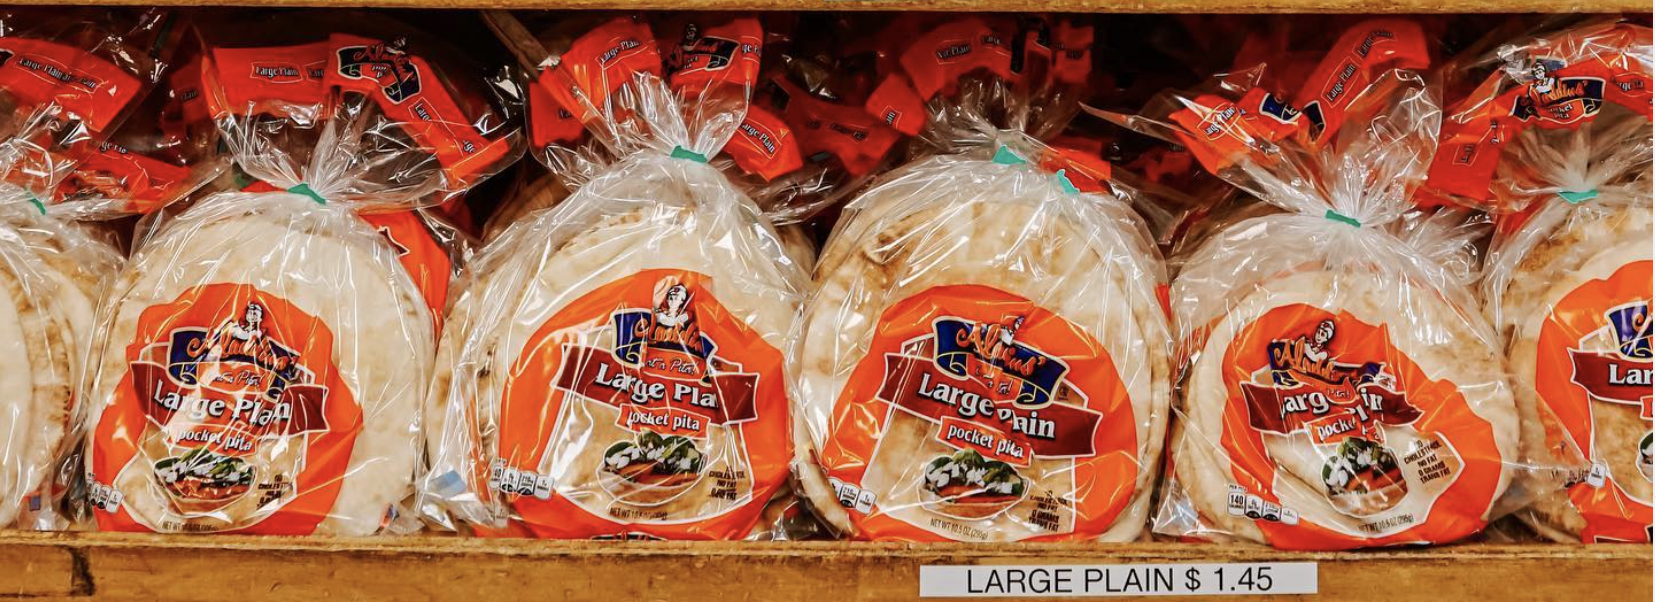

### by John Nahra

# Overview

My grandfather started a bakery in downtown Cleveland with his brother and his cousin over 50 years ago. They built up the business to be very successful and a Cleveland staple. It is a source of family pride, appreciation for my Lebanese roots, and delicious Mediterranean food!

The business has now passed onto the sons, my dad and his cousins, and is continuing to thrive. Still, businesses always have room for improvement. In talking with my dad, he identified a project centered around inventory management as a useful enterprise. In particular, the inventory management of pita bread in the store front. As the grandson of one of Aladdin's founders and its first data scientist, I jumped at the opportunity to help my family in a real-world capstone project.

The large majority of the business is baking pita bread that is then distributed to grocery stores. However, we also sell pita bread out of the store front, both to retail and wholesale customers. The store manager places bread orders five times per week for fresh bread to be baked and sold at the store the next day (or two). In its current state without using data, orders are more feel-driven. 

The impetus behind the project is to see if we can use data to better match orders to sales, thereby reducing the amount of bread that must be discounted as day old bread or discarded while at the same time ordering enough such that all who want delicious fresh pita bread are able to buy it.

There are several types of bread ordered, baked, and sold each day, but for the purposes of this project I focused only on one bread type: large plain pita bread.

Using daily data on store front transactions from January 2021 to March 2023, I was able to run a time series model to predict daily bread sales. I compared my sales predictions with the store front's bread orders over that same time frame and found that my predictions reduced the daily average order error by 25 and 33 packages of pita as compared with current orders on the train and test sets, respectively.

My 2023 sales forecast can be found in ['data/future_forecast.csv'](http://localhost:8888/edit/data/future_forecast.csv).

# Data Understanding

As mentioned above, I used daily data on store front transactions from January 2021 to March 2023. The data contained characteristics of each individual customer purchase: date, item, quantity, price, etc. 

I filtered for large plain pita bread sales only. I split those sales into retail and wholesale categories and modeled each category separately. 

Retail represents regular foot traffic. In the case of large plain pita, retail also represents customers who buy sandwiches, since large plain is used to make our shawarma wraps. Each package of pita contains five pieces of pita, thus five sandwiches is equivalent to one package of pita. 

Wholesale represents some of our wholesale customers who walk into the store front to buy bread. Generally, customers wanting more than 3 trays of bread (18 packages per tray, so 54 packages of pita) need to order ahead of time. Thus, I assumed in my model that any sale over 54 packages of pita would be known ahead of time. Most of these customers are wholesale customers, but there were a few retail customers who bought a large amount of bread as well.

For a baseline comparison, I utilized daily data on the store front's bread orders from January 2021 to March 2023. This data contained order characteristics such as date, customer ID, bread type, quantity, sale cost, etc.

For my more complex time series model with additional regressors, I added variables for Cleveland Guardians day home games and Cleveland weather features.

Aladdin's Baking Company is only a short walk from Progressive Field, the home of Cleveland's MLB franchise, so I wanted to see if pita sales were affected on days where the Guardians had a home game during the day time (defined as a game starting before 7 pm). It serves to reason that there may be some effect when there is greater foot traffic downtown (at least for sandwiches), though it could also dissuade would-be non-game-going customers from making the trip due to increased traffic. I utilized data from Baseball Reference to put together the Guardians home schedule from 2021-2023 (including playoffs), filtered for day games, and used game attendance as the variable. More fans, more traffic.

I also wanted to see if Cleveland weather could provide a more accurate, granular sales forecast outside of general annual seasonality. I gathered daily weather data from the National Oceanic and Atmospheric Administration for Cleveland Hopkins Airport, which is about 15 minutes away from the bakery. I was able to get features such as precipitation and snowfall in inches as well as maximum temperature for each day.

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/transaction items.csv')

In [3]:
df.head()

Time Register Name/Number Cashier Name Operation Type  \
0  03/13/2023 04:42 PM           Register 2    Dominic A           SALE   
1  03/13/2023 04:42 PM           Register 2    Dominic A           SALE   
2  03/13/2023 04:42 PM           Register 2    Dominic A           SALE   
3  03/13/2023 04:42 PM           Register 2    Dominic A           SALE   
4  03/13/2023 04:26 PM           Register 2    Dominic A           SALE   

      Store Code            UPC               Line Item    Department  \
0  *400000009773  *074265013280    ZIYAD HALVA /VANILLA       general   
1  *400000000428              *            Aladdin Bowl          Cafe   
2  *400000000084              *          Baklava Square          Cafe   
3  *400000008936              *       Lunch box special       general   
4  *400000007496              *  Specialty Retail Store  Retail Store   

         Category     Supplier  ...  Price  Quantity  Modifiers  Subtotal  \
0         general  not tracked  ...   4.99       1.0        0.0      4.99   
1  Aladdins Bowls  not tracked  ...  12.99       1.0        0.0     12.99   
2        Desserts  not tracked  ...   2.25       1.0        0.0      2.25   
3         general  not tracked  ...  10.99       1.0        0.0     10.99   
4         general  not tracked  ...   2.50       4.0        0.0     10.00   

   Discounts  Net Total  Tax  Total Due                        Transaction ID  \
0        0.0       4.99  0.0       4.99  6B3FCFA1-DAE7-4FE3-8764-9C6141D53256   
1        0.0      12.99  0.0      12.99  33EEC9A4-0917-4DF9-B870-E46B39E58ED9   
2        0.0       2.25  0.0       2.25  33EEC9A4-0917-4DF9-B870-E46B39E58ED9   
3        0.0      10.99  0.0      10.99  33EEC9A4-0917-4DF9-B870-E46B39E58ED9   
4        0.0      10.00  0.0      10.00  11046549-D002-411D-B9FC-994902E8DC16   

   Customer ID  
0     54861335  
1     54861335  
2     54861335  
3     54861335  
4     54861335  

[5 rows x 22 columns]

In [4]:
df_ws = df.loc[df['Line Item'] == 'Alad. Large Plain WS']

In [5]:
df = df.loc[(df["Line Item"] == 'Alad. Large Plain') | (df['Line Item'] == 'Lunch box special') | (df['Category'] == 'Stuffed Pita Sandwiches')]

In [6]:
def pita_package_count(row):
    if row['Category'] == 'Stuffed Pita Sandwiches' or row['Line Item'] == 'Lunch box special':
        return row['Quantity']/5
    else:
        return row['Quantity']

In [7]:
df['pita count'] = df.apply(pita_package_count,axis=1)

df_ws['pita count'] = df_ws.apply(pita_package_count,axis=1)

In [8]:
df.head(10)

Time Register Name/Number Cashier Name Operation Type  \
3   03/13/2023 04:42 PM           Register 2    Dominic A           SALE   
12  03/13/2023 04:24 PM           Register 2    Dominic A           SALE   
16  03/13/2023 04:20 PM           Register 2    Dominic A           SALE   
28  03/13/2023 04:09 PM           Register 2    Dominic A           SALE   
31  03/13/2023 04:03 PM           Register 2    Dominic A           SALE   
35  03/13/2023 03:57 PM           Register 2    Dominic A           SALE   
36  03/13/2023 03:49 PM           Register 2    Dominic A           SALE   
67  03/13/2023 03:14 PM           Register 2    Dominic A           SALE   
84  03/13/2023 02:53 PM           Register 2    Dominic A           SALE   
87  03/13/2023 02:53 PM           Register 2    Dominic A           SALE   

       Store Code            UPC                      Line Item    Department  \
3   *400000008936              *              Lunch box special       general   
12  *400000000343              *  Falafel Sandwich (Vegetarian)          Cafe   
16  *400000000305              *               Chicken Shawarma          Cafe   
28  *400000000305              *               Chicken Shawarma          Cafe   
31  *400000000336              *                  Gyro Sandwich          Cafe   
35  *400000000305              *               Chicken Shawarma          Cafe   
36  *400000001012  *073998126700              Alad. Large Plain  Retail Store   
67  *400000000305              *               Chicken Shawarma          Cafe   
84  *400000001012  *073998126700              Alad. Large Plain  Retail Store   
87  *400000000336              *                  Gyro Sandwich          Cafe   

                   Category     Supplier  ...  Quantity  Modifiers  Subtotal  \
3                   general  not tracked  ...       1.0        0.0     10.99   
12  Stuffed Pita Sandwiches  not tracked  ...       1.0        0.0      7.99   
16  Stuffed Pita Sandwiches  not tracked  ...       1.0        0.0      8.99   
28  Stuffed Pita Sandwiches  not tracked  ...       2.0        0.0     17.98   
31  Stuffed Pita Sandwiches  not tracked  ...       1.0        0.0      8.99   
35  Stuffed Pita Sandwiches  not tracked  ...       2.0        0.0     17.98   
36                    Bread  not tracked  ...       4.0        0.0      7.20   
67  Stuffed Pita Sandwiches  not tracked  ...       2.0        0.0     17.98   
84                    Bread  not tracked  ...       2.0        0.0      3.60   
87  Stuffed Pita Sandwiches  not tracked  ...       1.0        0.0      8.99   

    Discounts  Net Total  Tax  Total Due  \
3         0.0      10.99  0.0      10.99   
12        0.0       7.99  0.0       7.99   
16        0.0       8.99  0.0       8.99   
28        0.0      17.98  0.0      17.98   
31        0.0       8.99  0.0       8.99   
35        0.0      17.98  0.0      17.98   
36        0.0       7.20  0.0       7.20   
67        0.0      17.98  0.0      17.98   
84        0.0       3.60  0.0       3.60   
87        0.0       8.99  0.0       8.99   

                          Transaction ID  Customer ID  pita count  
3   33EEC9A4-0917-4DF9-B870-E46B39E58ED9     54861335         0.2  
12  57B1276C-0C1B-4DD8-A2AC-63053635D3B8     54861335         0.2  
16  43D79AC2-5BD8-45AD-83F4-204B95851517     54861335         0.2  
28  FFEDA654-27DA-4EE3-AE9E-04DC9E4C248F     54861335         0.4  
31  6F9B2F9B-3D76-45A4-8087-A17F58C428A4     54861335         0.2  
35  CF7CC33B-5A05-4DBD-B9CC-5293678C15A4     54861335         0.4  
36  26FBC13B-6AAC-41B1-8450-6AABC3DC93C7     54861335         4.0  
67  E51500F6-E167-4886-837F-B01BFA3160D8     54861335         0.4  
84  F9A681E6-3F3A-4217-96BB-AEEB6B7906C8     54861335         2.0  
87  F9A681E6-3F3A-4217-96BB-AEEB6B7906C8     54861335         0.2  

[10 rows x 23 columns]

In [9]:
def unit_cost(row):
    if row['Category'] == 'Stuffed Pita Sandwiches' or row['Line Item'] == 'Lunch box special':
        return 0
    else:
        return round(row['Total Due']/row['Quantity'],2)

df['unit cost'] = df.apply(unit_cost,axis=1)

df_ws['unit cost'] = df_ws.apply(unit_cost,axis=1)

In [10]:
df['unit cost'].value_counts()

 0.00    31826
 1.45     5106
 1.80     3096
 1.60     2595
 1.44       81
 1.30       72
 1.62       68
 1.16       49
 1.31       25
-1.80        8
-1.45        4
 1.23        2
 1.27        1
 1.26        1
 1.77        1
 1.38        1
 1.52        1
 1.17        1
 0.90        1
 1.01        1
 1.48        1
 1.02        1
 1.28        1
 1.71        1
-1.60        1
Name: unit cost, dtype: int64

In [11]:
df_ws['unit cost'].value_counts()

 1.32    325
 1.20    139
 1.55    132
 1.19      5
 1.08      3
-1.32      1
 0.20      1
 0.98      1
 1.28      1
 1.39      1
 1.24      1
Name: unit cost, dtype: int64

In [12]:
df_ws.loc[df_ws['unit cost'] == -1.32]

Time Register Name/Number Cashier Name Operation Type  \
105321  08/27/2022 02:26 PM           Register 2    Dominic A         RETURN   

           Store Code UPC             Line Item Department Category  \
105321  *400000000251   *  Alad. Large Plain WS  WholeSale    Bread   

           Supplier  ...  Modifiers  Subtotal  Discounts  Net Total  Tax  \
105321  not tracked  ...        0.0      -6.6        0.0       -6.6  0.0   

        Total Due                        Transaction ID  Customer ID  \
105321       -6.6  D6F0F52D-9A68-42A6-B4A0-CD074D783A75     54861335   

        pita count  unit cost  
105321         5.0      -1.32  

[1 rows x 24 columns]

In [13]:
df_all = df.copy()

df_all_ws = df_ws.copy()

In [14]:
df_all['date'] = pd.to_datetime(df_all['Time'])

df_all_ws['date'] = pd.to_datetime(df_all_ws['Time'])

In [15]:
df_all.set_index('date',inplace=True)

df_all_ws.set_index('date',inplace=True)

In [16]:
df_all_daily = df_all['pita count'].resample('D').sum()

df_all_ws_daily = df_all_ws['pita count'].resample('D').sum()

In [17]:
total_sales_plus = df_all_daily.to_frame().merge(df_all_ws_daily.to_frame(),left_index=True,right_index=True)

In [18]:
total_sales_plus = total_sales_plus.rename({'pita count_x': 'retail_sales','pita count_y':'wholesale_sales'},axis=1)

In [19]:
total_sales_plus['total_sales'] = total_sales_plus['retail_sales'] + total_sales_plus['wholesale_sales']

In [20]:
total_sales_plus.head()

retail_sales  wholesale_sales  total_sales
date                                                  
2021-01-12           0.2              1.0          1.2
2021-01-13           1.4              0.0          1.4
2021-01-14          47.0             30.0         77.0
2021-01-15          58.8             12.0         70.8
2021-01-16         164.4              0.0        164.4

In [21]:
total_sales_plus.to_csv('data/total_large_white_plain_sales_plus.csv')

In [22]:
df = df.loc[df['pita count']<=54]

df_ws = df_ws.loc[df_ws['pita count']<=54]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42937 entries, 3 to 429939
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  42937 non-null  object 
 1   Register Name/Number  42937 non-null  object 
 2   Cashier Name          42937 non-null  object 
 3   Operation Type        42937 non-null  object 
 4   Store Code            42937 non-null  object 
 5   UPC                   42937 non-null  object 
 6   Line Item             42937 non-null  object 
 7   Department            42937 non-null  object 
 8   Category              42937 non-null  object 
 9   Supplier              42937 non-null  object 
 10  Supplier Code         0 non-null      float64
 11  Cost                  42937 non-null  float64
 12  Price                 42937 non-null  float64
 13  Quantity              42937 non-null  float64
 14  Modifiers             42937 non-null  float64
 15  Subtotal          

In [24]:
df['date'] = pd.to_datetime(df['Time'])

df_ws['date'] = pd.to_datetime(df_ws['Time'])

In [25]:
df.set_index('date',inplace=True)

df_ws.set_index('date',inplace=True)

In [26]:
df_daily = df['pita count'].resample('D').sum()

df_ws_daily = df_ws['pita count'].resample('D').sum()

In [27]:
df_daily.to_csv('data/large_white_plain_sales.csv')

df_ws_daily.to_csv('data/large_white_plain_ws_sales.csv')

In [28]:
total_sales = df_daily.to_frame().merge(df_ws_daily.to_frame(),left_index=True,right_index=True)

In [29]:
total_sales.head()

pita count_x  pita count_y
date                                  
2021-01-12           0.2           1.0
2021-01-13           1.4           0.0
2021-01-14          47.0          30.0
2021-01-15          58.8          12.0
2021-01-16         164.4           0.0

In [30]:
total_sales = total_sales.rename({'pita count_x': 'retail_sales','pita count_y':'wholesale_sales'},axis=1)

In [31]:
total_sales['total_sales'] = total_sales['retail_sales'] + total_sales['wholesale_sales']

In [32]:
total_sales.head()

retail_sales  wholesale_sales  total_sales
date                                                  
2021-01-12           0.2              1.0          1.2
2021-01-13           1.4              0.0          1.4
2021-01-14          47.0             30.0         77.0
2021-01-15          58.8             12.0         70.8
2021-01-16         164.4              0.0        164.4

In [33]:
total_sales.to_csv('data/total_large_white_plain_sales.csv')

In [34]:
df_daily.head()

date
2021-01-12      0.2
2021-01-13      1.4
2021-01-14     47.0
2021-01-15     58.8
2021-01-16    164.4
Freq: D, Name: pita count, dtype: float64

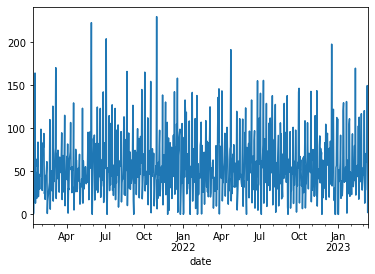

In [35]:
df_daily.plot();

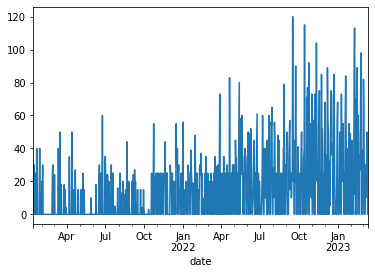

In [36]:
df_ws_daily.plot();

In [37]:
index = pd.date_range(start='1/1/2021',end='12/31/2023')

In [38]:
index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=1095, freq='D')

In [39]:
df_daily = df_daily.reindex(index)

df_ws_daily = df_ws_daily.reindex(index)

In [40]:
df_daily.head()

2021-01-01   NaN
2021-01-02   NaN
2021-01-03   NaN
2021-01-04   NaN
2021-01-05   NaN
Freq: D, Name: pita count, dtype: float64

In [41]:
df_daily.sort_values(ascending=False)[:10]

2021-10-30    230.0
2021-05-29    223.0
2021-07-03    204.2
2022-12-17    198.0
2022-04-23    191.6
2021-03-06    170.6
2023-02-11    170.0
2021-08-21    166.2
2021-10-02    165.4
2021-01-16    164.4
Name: pita count, dtype: float64

In [42]:
df_daily.describe()

count    791.000000
mean      56.664475
std       35.992689
min        0.000000
25%       33.200000
50%       49.800000
75%       73.400000
max      230.000000
Name: pita count, dtype: float64

In [43]:
df_ws_daily.sort_values(ascending=False)[:10]

2022-09-16    120.0
2022-10-14    115.0
2023-02-09    113.0
2022-11-11    104.0
2023-02-24     98.0
2023-02-08     94.0
2022-10-24     92.0
2022-09-23     90.0
2022-12-07     89.0
2023-02-15     89.0
Name: pita count, dtype: float64

In [44]:
df_ws_daily.describe()

count    791.000000
mean      15.815424
std       21.741084
min        0.000000
25%        0.000000
50%        0.000000
75%       25.000000
max      120.000000
Name: pita count, dtype: float64

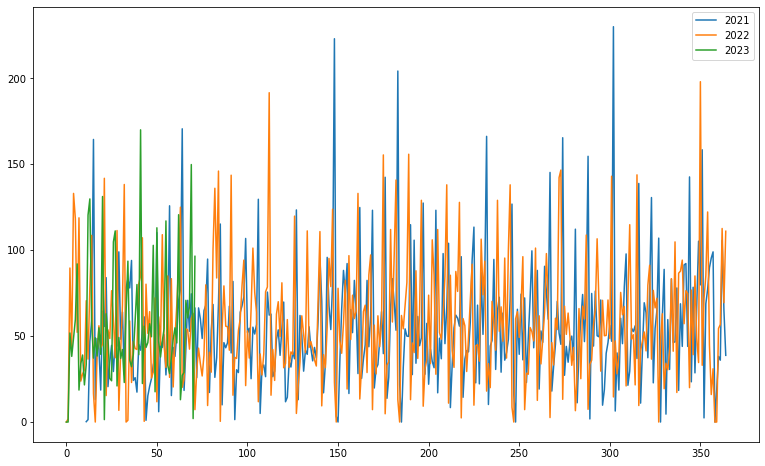

In [45]:
year_groups = df_daily.groupby(pd.Grouper(freq='A'))
pita_annual = pd.DataFrame()
for yr,group in year_groups:
    pita_annual[yr.year] = group.values.ravel()
pita_annual.plot(figsize=(13,8),subplots=False,legend=True);

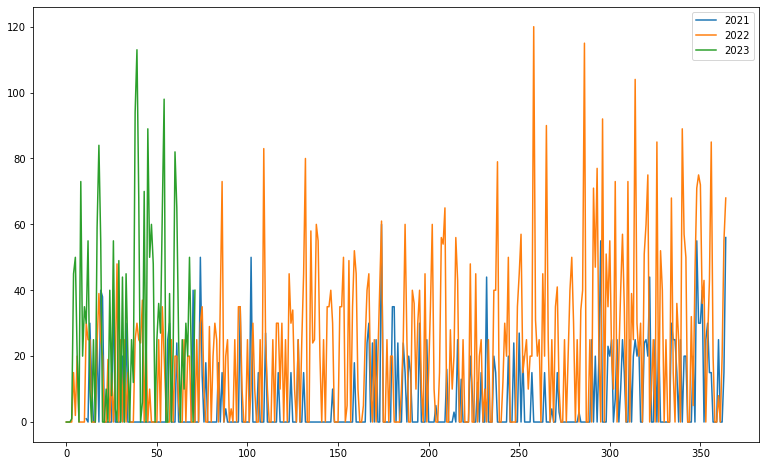

In [46]:
year_groups = df_ws_daily.groupby(pd.Grouper(freq='A'))
pita_annual = pd.DataFrame()
for yr,group in year_groups:
    pita_annual[yr.year] = group.values.ravel()
pita_annual.plot(figsize=(13,8),subplots=False,legend=True);

In [47]:
df_daily.head(20)

2021-01-01      NaN
2021-01-02      NaN
2021-01-03      NaN
2021-01-04      NaN
2021-01-05      NaN
2021-01-06      NaN
2021-01-07      NaN
2021-01-08      NaN
2021-01-09      NaN
2021-01-10      NaN
2021-01-11      NaN
2021-01-12      0.2
2021-01-13      1.4
2021-01-14     47.0
2021-01-15     58.8
2021-01-16    164.4
2021-01-17     13.0
2021-01-18     48.6
2021-01-19     42.4
2021-01-20     18.6
Freq: D, Name: pita count, dtype: float64

In [48]:
df_daily_na = df_daily.dropna()

df_ws_daily_na = df_ws_daily.dropna()

## Additional Regressors Data Preparation

### Guardians Day Home Games

In [49]:
df_2021 = pd.read_csv('data/guards2021.csv',header=1)

In [50]:
df_2021.head()

Unnamed: 0  Gm#             Date Unnamed: 3   Tm Unnamed: 5  Opp W/L  R  \
0         NaN    1   Thursday Apr 1   boxscore  CLE          @  DET   L  2   
1         NaN    2   Saturday Apr 3   boxscore  CLE          @  DET   L  2   
2         NaN    3     Sunday Apr 4   boxscore  CLE          @  DET   W  9   
3         NaN    4     Monday Apr 5   boxscore  CLE        NaN  KCR   L  0   
4         NaN    5  Wednesday Apr 7   boxscore  CLE        NaN  KCR   W  4   

   RA  ...   GB      Win     Loss      Save  Time D/N Attendance   cLI Streak  \
0   3  ...  1.0     Boyd   Bieber      Soto  3:03   D     8000.0  1.08      -   
1   5  ...  2.0  Teheran   Plesac    Garcia  3:17   D     8000.0  1.03     --   
2   3  ...  1.0   Civale   Norris       NaN  2:38   D     8000.0  0.96      +   
3   3  ...  2.0    Duffy    Allen      Hahn  2:52   D     8914.0  1.03      -   
4   2  ...  1.5    Clase  Holland  Wittgren  2:53   D     5908.0  0.93      +   

   Orig. Scheduled  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 23 columns]

In [51]:
df_2022 = pd.read_csv('data/guards2022.csv',header=1)

In [52]:
df_2022.head()

Unnamed: 0  Gm#            Date Unnamed: 3   Tm Unnamed: 5  Opp   W/L   R  \
0         NaN    1  Thursday Apr 7   boxscore  CLE          @  KCR     L   1   
1         NaN    2  Saturday Apr 9   boxscore  CLE          @  KCR  L-wo   0   
2         NaN    3   Sunday Apr 10   boxscore  CLE          @  KCR     W  17   
3         NaN    4   Monday Apr 11   boxscore  CLE          @  KCR     W  10   
4         NaN    5  Tuesday Apr 12   boxscore  CLE          @  CIN     W  10   

   RA  ...   GB        Win        Loss Save  Time D/N Attendance   cLI Streak  \
0   3  ...  1.0     Barlow    McKenzie  NaN  2:49   D    28459.0  1.02      -   
1   1  ...  2.0     Snider       Clase  NaN  2:49   D    17103.0  0.95     --   
2   3  ...  1.0  Quantrill       Bubic  NaN  3:09   D    20165.0  0.92      +   
3   7  ...  0.5      Allen      Brentz  NaN  3:37   D     8971.0  0.98     ++   
4   5  ...  0.5    Stephan  Strickland  NaN  3:30   D    43036.0  0.91    +++   

   Orig. Scheduled  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 23 columns]

In [53]:
df_2023 = pd.read_csv('data/guards2023.csv')

In [54]:
df_2023.head()

START DATE START TIME START TIME ET               SUBJECT  \
0   02/26/23   01:05 PM      03:05 PM  Rangers at Guardians   
1   02/28/23   01:05 PM      03:05 PM   Royals at Guardians   
2   03/02/23   01:05 PM      03:05 PM   Giants at Guardians   
3   03/03/23   01:05 PM      03:05 PM  Brewers at Guardians   
4   03/05/23   01:05 PM      03:05 PM  D-backs at Guardians   

                       LOCATION  \
0  Goodyear Ballpark - Goodyear   
1  Goodyear Ballpark - Goodyear   
2  Goodyear Ballpark - Goodyear   
3  Goodyear Ballpark - Goodyear   
4  Goodyear Ballpark - Goodyear   

                                         DESCRIPTION  END DATE END DATE ET  \
0                             Local Radio: WTAM 1100  02/26/23    02/26/23   
1  Local TV: Bally Sports Great Lakes ----- Local...  02/28/23    02/28/23   
2                             Local Radio: WTAM 1100  03/02/23    03/02/23   
3                                                NaN  03/03/23    03/03/23   
4                                                NaN  03/05/23    03/05/23   

   END TIME END TIME ET  REMINDER OFF  REMINDER ON REMINDER DATE  \
0  04:05 PM    06:05 PM         False         True      02/26/23   
1  04:05 PM    06:05 PM         False         True      02/28/23   
2  04:05 PM    06:05 PM         False         True      03/02/23   
3  04:05 PM    06:05 PM         False         True      03/03/23   
4  04:05 PM    06:05 PM         False         True      03/05/23   

  REMINDER TIME REMINDER TIME ET SHOWTIMEAS FREE SHOWTIMEAS BUSY  
0      12:05 PM         02:05 PM            FREE            BUSY  
1      12:05 PM         02:05 PM            FREE            BUSY  
2      12:05 PM         02:05 PM            FREE            BUSY  
3      12:05 PM         02:05 PM            FREE            BUSY  
4      12:05 PM         02:05 PM            FREE            BUSY

In [55]:
df_2023['START TIME ET'].value_counts()

07:10 PM    33
06:10 PM    20
01:40 PM    11
01:10 PM     9
03:05 PM     8
04:05 PM     5
04:10 PM     4
07:15 PM     2
09:05 PM     2
12:05 PM     1
11:35 AM     1
Name: START TIME ET, dtype: int64

In [56]:
df_2023 = df_2023.loc[df_2023['LOCATION'] == 'Progressive Field - Cleveland']

In [57]:
df_2023['START TIME ET'].value_counts()

07:10 PM    33
06:10 PM    20
01:40 PM    11
01:10 PM     9
04:10 PM     4
07:15 PM     2
12:05 PM     1
11:35 AM     1
Name: START TIME ET, dtype: int64

In [58]:
df_2023 = df_2023[~df_2023['START TIME ET'].isin(['07:10 PM','07:15 PM'])]

In [59]:
df_2023['START TIME ET'].value_counts()

06:10 PM    20
01:40 PM    11
01:10 PM     9
04:10 PM     4
12:05 PM     1
11:35 AM     1
Name: START TIME ET, dtype: int64

In [60]:
df_2023 = df_2023.rename({'START DATE':'Date'},axis=1)

In [61]:
df_2023['Date'] = pd.to_datetime(df_2023['Date'])

In [62]:
df_2023.set_index('Date',inplace=True)

In [63]:
df_2023['day'] = df_2023.index.day_name()

In [64]:
df_2023.head()

START TIME START TIME ET                SUBJECT  \
Date                                                         
2023-04-07   04:10 PM      04:10 PM  Mariners at Guardians   
2023-04-08   06:10 PM      06:10 PM  Mariners at Guardians   
2023-04-09   01:40 PM      01:40 PM  Mariners at Guardians   
2023-04-10   06:10 PM      06:10 PM   Yankees at Guardians   
2023-04-11   06:10 PM      06:10 PM   Yankees at Guardians   

                                 LOCATION  \
Date                                        
2023-04-07  Progressive Field - Cleveland   
2023-04-08  Progressive Field - Cleveland   
2023-04-09  Progressive Field - Cleveland   
2023-04-10  Progressive Field - Cleveland   
2023-04-11  Progressive Field - Cleveland   

                                                  DESCRIPTION  END DATE  \
Date                                                                      
2023-04-07  Local TV: Bally Sports Great Lakes ----- Local...  04/07/23   
2023-04-08  Local TV: Bally Sports Great Lakes ----- Local...  04/08/23   
2023-04-09  Local TV: Bally Sports Great Lakes ----- Local...  04/09/23   
2023-04-10                                                NaN  04/10/23   
2023-04-11                                                NaN  04/11/23   

           END DATE ET  END TIME END TIME ET  REMINDER OFF  REMINDER ON  \
Date                                                                      
2023-04-07    04/07/23  07:10 PM    07:10 PM         False         True   
2023-04-08    04/08/23  09:10 PM    09:10 PM         False         True   
2023-04-09    04/09/23  04:40 PM    04:40 PM         False         True   
2023-04-10    04/10/23  09:10 PM    09:10 PM         False         True   
2023-04-11    04/11/23  09:10 PM    09:10 PM         False         True   

           REMINDER DATE REMINDER TIME REMINDER TIME ET SHOWTIMEAS FREE  \
Date                                                                      
2023-04-07      04/07/23      03:10 PM         03:10 PM            FREE   
2023-04-08      04/08/23      05:10 PM         05:10 PM            FREE   
2023-04-09      04/09/23      12:40 PM         12:40 PM            FREE   
2023-04-10      04/10/23      05:10 PM         05:10 PM            FREE   
2023-04-11      04/11/23      05:10 PM         05:10 PM            FREE   

           SHOWTIMEAS BUSY       day  
Date                                  
2023-04-07            BUSY    Friday  
2023-04-08            BUSY  Saturday  
2023-04-09            BUSY    Sunday  
2023-04-10            BUSY    Monday  
2023-04-11            BUSY   Tuesday

In [65]:
df_2021.head()

Unnamed: 0  Gm#             Date Unnamed: 3   Tm Unnamed: 5  Opp W/L  R  \
0         NaN    1   Thursday Apr 1   boxscore  CLE          @  DET   L  2   
1         NaN    2   Saturday Apr 3   boxscore  CLE          @  DET   L  2   
2         NaN    3     Sunday Apr 4   boxscore  CLE          @  DET   W  9   
3         NaN    4     Monday Apr 5   boxscore  CLE        NaN  KCR   L  0   
4         NaN    5  Wednesday Apr 7   boxscore  CLE        NaN  KCR   W  4   

   RA  ...   GB      Win     Loss      Save  Time D/N Attendance   cLI Streak  \
0   3  ...  1.0     Boyd   Bieber      Soto  3:03   D     8000.0  1.08      -   
1   5  ...  2.0  Teheran   Plesac    Garcia  3:17   D     8000.0  1.03     --   
2   3  ...  1.0   Civale   Norris       NaN  2:38   D     8000.0  0.96      +   
3   3  ...  2.0    Duffy    Allen      Hahn  2:52   D     8914.0  1.03      -   
4   2  ...  1.5    Clase  Holland  Wittgren  2:53   D     5908.0  0.93      +   

   Orig. Scheduled  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 23 columns]

In [66]:
df_2021 = df_2021.rename({'Unnamed: 5': 'home'},axis=1)

df_2022 = df_2022.rename({'Unnamed: 5': 'home'},axis=1)

In [67]:
df_2021.head()

Unnamed: 0  Gm#             Date Unnamed: 3   Tm home  Opp W/L  R  RA  ...  \
0         NaN    1   Thursday Apr 1   boxscore  CLE    @  DET   L  2   3  ...   
1         NaN    2   Saturday Apr 3   boxscore  CLE    @  DET   L  2   5  ...   
2         NaN    3     Sunday Apr 4   boxscore  CLE    @  DET   W  9   3  ...   
3         NaN    4     Monday Apr 5   boxscore  CLE  NaN  KCR   L  0   3  ...   
4         NaN    5  Wednesday Apr 7   boxscore  CLE  NaN  KCR   W  4   2  ...   

    GB      Win     Loss      Save  Time D/N Attendance   cLI Streak  \
0  1.0     Boyd   Bieber      Soto  3:03   D     8000.0  1.08      -   
1  2.0  Teheran   Plesac    Garcia  3:17   D     8000.0  1.03     --   
2  1.0   Civale   Norris       NaN  2:38   D     8000.0  0.96      +   
3  2.0    Duffy    Allen      Hahn  2:52   D     8914.0  1.03      -   
4  1.5    Clase  Holland  Wittgren  2:53   D     5908.0  0.93      +   

   Orig. Scheduled  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 23 columns]

In [68]:
df_2021 = df_2021[['Date','Attendance']].loc[(df_2021['home'] != '@') & (df_2021['D/N'] == 'D')]

df_2022 = df_2022[['Date','Attendance']].loc[(df_2022['home'] != '@') & (df_2022['D/N'] == 'D')]

In [69]:
df_2021

Date  Attendance
3            Monday Apr 5      8914.0
4         Wednesday Apr 7      5908.0
7           Sunday Apr 11      6859.0
19          Sunday Apr 25      8766.0
22       Wednesday Apr 28      5903.0
33       Wednesday May 12      8589.0
42        Saturday May 22     11505.0
43          Sunday May 23      9805.0
49      Sunday May 30 (1)         NaN
50      Sunday May 30 (2)     11690.0
51      Monday May 31 (1)         NaN
60        Saturday Jun 12     20116.0
61          Sunday Jun 13     17371.0
65        Thursday Jun 17     15121.0
75   Wednesday Jun 30 (1)         NaN
80           Sunday Jul 4     17412.0
96          Sunday Jul 25     18614.0
98       Wednesday Jul 28     19927.0
108          Sunday Aug 8     19899.0
112       Thursday Aug 12     16559.0
120       Saturday Aug 21     31406.0
126       Saturday Aug 28     26221.0
127         Sunday Aug 29     22883.0
140         Sunday Sep 12     16332.0
147     Monday Sep 20 (1)         NaN
150   Thursday Sep 23 (1)     11851.0
154         Sunday Sep 26     21957.0
155         Monday Sep 27     13121.0

In [70]:
df_2022

Date  Attendance
8           Sunday Apr 17      9620.0
9    Wednesday Apr 20 (1)         NaN
10   Wednesday Apr 20 (2)      9196.0
11        Thursday Apr 21      8345.0
22    Wednesday May 4 (1)         NaN
23    Wednesday May 4 (2)     10244.0
25     Saturday May 7 (1)         NaN
26     Saturday May 7 (2)     16819.0
27           Sunday May 8     14787.0
34        Thursday May 19      8510.0
36          Sunday May 22     15554.0
45        Wednesday Jun 1     12895.0
49      Tuesday Jun 7 (1)         NaN
50      Tuesday Jun 7 (2)     10763.0
54        Saturday Jun 11     22674.0
55          Sunday Jun 12     17776.0
67          Sunday Jun 26     20663.0
69     Tuesday Jun 28 (1)     12442.0
72        Thursday Jun 30     17066.0
73     Saturday Jul 2 (1)     21203.0
75           Sunday Jul 3     26113.0
84     Tuesday Jul 12 (1)     11342.0
89        Saturday Jul 16     26789.0
103       Wednesday Aug 3     18642.0
107          Sunday Aug 7     22688.0
114     Monday Aug 15 (1)         NaN
115     Monday Aug 15 (2)     16980.0
131          Sunday Sep 4     17809.0
140      Wednesday Sep 14     14529.0
141       Thursday Sep 15     11186.0
143   Saturday Sep 17 (1)     18177.0
145         Sunday Sep 18     19601.0
146         Monday Sep 19     12168.0
158          Sunday Oct 2     20622.0
161       Wednesday Oct 5     12983.0

In [71]:
df_2021['Date'].iloc[0].split()[0]

'Monday'

In [72]:
from statistics import mean
def attendance_filler(df, day):
    attendance = []
    for i in range(0,len(df)):
        if df['Date'].iloc[i].split()[0] == day:
            attendance.append(df['Attendance'].iloc[i])
    if len(attendance) > 0:
        return sum(attendance)/len(attendance)
    else:
        return 'N/A'

In [73]:
week = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
dict_2021 = {}
for day in week:
    dict_2021[day] = attendance_filler(df_2021.dropna(),day)
dict_2021

{'Sunday': 15598.90909090909,
 'Monday': 11017.5,
 'Tuesday': 'N/A',
 'Wednesday': 10081.75,
 'Thursday': 14510.333333333334,
 'Friday': 'N/A',
 'Saturday': 22312.0}

In [74]:
dict_2022 = {}
for day in week:
    dict_2022[day] = attendance_filler(df_2022.dropna(),day)
dict_2022['Friday'] = 17000
dict_2022

{'Sunday': 18523.3,
 'Monday': 14574.0,
 'Tuesday': 11515.666666666666,
 'Wednesday': 13081.5,
 'Thursday': 11276.75,
 'Friday': 17000,
 'Saturday': 21132.4}

In [75]:
df_2023['Attendance'] = df_2023['day'].map(dict_2022)

In [76]:
df_2023.head()

START TIME START TIME ET                SUBJECT  \
Date                                                         
2023-04-07   04:10 PM      04:10 PM  Mariners at Guardians   
2023-04-08   06:10 PM      06:10 PM  Mariners at Guardians   
2023-04-09   01:40 PM      01:40 PM  Mariners at Guardians   
2023-04-10   06:10 PM      06:10 PM   Yankees at Guardians   
2023-04-11   06:10 PM      06:10 PM   Yankees at Guardians   

                                 LOCATION  \
Date                                        
2023-04-07  Progressive Field - Cleveland   
2023-04-08  Progressive Field - Cleveland   
2023-04-09  Progressive Field - Cleveland   
2023-04-10  Progressive Field - Cleveland   
2023-04-11  Progressive Field - Cleveland   

                                                  DESCRIPTION  END DATE  \
Date                                                                      
2023-04-07  Local TV: Bally Sports Great Lakes ----- Local...  04/07/23   
2023-04-08  Local TV: Bally Sports Great Lakes ----- Local...  04/08/23   
2023-04-09  Local TV: Bally Sports Great Lakes ----- Local...  04/09/23   
2023-04-10                                                NaN  04/10/23   
2023-04-11                                                NaN  04/11/23   

           END DATE ET  END TIME END TIME ET  REMINDER OFF  REMINDER ON  \
Date                                                                      
2023-04-07    04/07/23  07:10 PM    07:10 PM         False         True   
2023-04-08    04/08/23  09:10 PM    09:10 PM         False         True   
2023-04-09    04/09/23  04:40 PM    04:40 PM         False         True   
2023-04-10    04/10/23  09:10 PM    09:10 PM         False         True   
2023-04-11    04/11/23  09:10 PM    09:10 PM         False         True   

           REMINDER DATE REMINDER TIME REMINDER TIME ET SHOWTIMEAS FREE  \
Date                                                                      
2023-04-07      04/07/23      03:10 PM         03:10 PM            FREE   
2023-04-08      04/08/23      05:10 PM         05:10 PM            FREE   
2023-04-09      04/09/23      12:40 PM         12:40 PM            FREE   
2023-04-10      04/10/23      05:10 PM         05:10 PM            FREE   
2023-04-11      04/11/23      05:10 PM         05:10 PM            FREE   

           SHOWTIMEAS BUSY       day    Attendance  
Date                                                
2023-04-07            BUSY    Friday  17000.000000  
2023-04-08            BUSY  Saturday  21132.400000  
2023-04-09            BUSY    Sunday  18523.300000  
2023-04-10            BUSY    Monday  14574.000000  
2023-04-11            BUSY   Tuesday  11515.666667

In [77]:
df_2023 = pd.DataFrame(df_2023['Attendance'])

In [78]:
df_2023

Attendance
Date                    
2023-04-07  17000.000000
2023-04-08  21132.400000
2023-04-09  18523.300000
2023-04-10  14574.000000
2023-04-11  11515.666667
2023-04-12  13081.500000
2023-04-22  21132.400000
2023-04-23  18523.300000
2023-04-24  14574.000000
2023-04-25  11515.666667
2023-04-26  13081.500000
2023-05-06  21132.400000
2023-05-07  18523.300000
2023-05-08  14574.000000
2023-05-09  11515.666667
2023-05-10  13081.500000
2023-05-13  21132.400000
2023-05-14  18523.300000
2023-05-22  14574.000000
2023-05-23  11515.666667
2023-05-24  13081.500000
2023-05-28  18523.300000
2023-06-10  21132.400000
2023-06-11  18523.300000
2023-06-22  11276.750000
2023-06-24  21132.400000
2023-06-25  18523.300000
2023-07-08  21132.400000
2023-07-09  18523.300000
2023-07-23  18523.300000
2023-07-26  13081.500000
2023-08-06  18523.300000
2023-08-10  11276.750000
2023-08-20  18523.300000
2023-08-24  11276.750000
2023-09-02  21132.400000
2023-09-03  18523.300000
2023-09-04  14574.000000
2023-09-05  11515.666667
2023-09-06  13081.500000
2023-09-16  21132.400000
2023-09-17  18523.300000
2023-09-23  21132.400000
2023-09-24  18523.300000
2023-09-26  11515.666667
2023-09-27  13081.500000

In [79]:
missing_2021 = df_2021['Date'].loc[df_2021['Attendance'].isna()]

missing_2022 = df_2022['Date'].loc[df_2022['Attendance'].isna()]

In [80]:
missing_2021

49        Sunday May 30 (1)
51        Monday May 31 (1)
75     Wednesday Jun 30 (1)
147       Monday Sep 20 (1)
Name: Date, dtype: object

In [81]:
missing_2022

9      Wednesday Apr 20 (1)
22      Wednesday May 4 (1)
25       Saturday May 7 (1)
49        Tuesday Jun 7 (1)
114       Monday Aug 15 (1)
Name: Date, dtype: object

In [82]:
for date in missing_2021:
    for i in range(0,len(df_2021)):
        if df_2021['Date'].iloc[i] == date:
            df_2021['Attendance'].iloc[i] = attendance_filler(df_2021.dropna(),date.split()[0])

/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [83]:
df_2022 = df_2022.dropna()

In [84]:
df_2021 = df_2021.drop(49)

In [85]:
df_2021

Date  Attendance
3            Monday Apr 5     8914.00
4         Wednesday Apr 7     5908.00
7           Sunday Apr 11     6859.00
19          Sunday Apr 25     8766.00
22       Wednesday Apr 28     5903.00
33       Wednesday May 12     8589.00
42        Saturday May 22    11505.00
43          Sunday May 23     9805.00
50      Sunday May 30 (2)    11690.00
51      Monday May 31 (1)    11017.50
60        Saturday Jun 12    20116.00
61          Sunday Jun 13    17371.00
65        Thursday Jun 17    15121.00
75   Wednesday Jun 30 (1)    10081.75
80           Sunday Jul 4    17412.00
96          Sunday Jul 25    18614.00
98       Wednesday Jul 28    19927.00
108          Sunday Aug 8    19899.00
112       Thursday Aug 12    16559.00
120       Saturday Aug 21    31406.00
126       Saturday Aug 28    26221.00
127         Sunday Aug 29    22883.00
140         Sunday Sep 12    16332.00
147     Monday Sep 20 (1)    11017.50
150   Thursday Sep 23 (1)    11851.00
154         Sunday Sep 26    21957.00
155         Monday Sep 27    13121.00

In [86]:
df_2022

Date  Attendance
8           Sunday Apr 17      9620.0
10   Wednesday Apr 20 (2)      9196.0
11        Thursday Apr 21      8345.0
23    Wednesday May 4 (2)     10244.0
26     Saturday May 7 (2)     16819.0
27           Sunday May 8     14787.0
34        Thursday May 19      8510.0
36          Sunday May 22     15554.0
45        Wednesday Jun 1     12895.0
50      Tuesday Jun 7 (2)     10763.0
54        Saturday Jun 11     22674.0
55          Sunday Jun 12     17776.0
67          Sunday Jun 26     20663.0
69     Tuesday Jun 28 (1)     12442.0
72        Thursday Jun 30     17066.0
73     Saturday Jul 2 (1)     21203.0
75           Sunday Jul 3     26113.0
84     Tuesday Jul 12 (1)     11342.0
89        Saturday Jul 16     26789.0
103       Wednesday Aug 3     18642.0
107          Sunday Aug 7     22688.0
115     Monday Aug 15 (2)     16980.0
131          Sunday Sep 4     17809.0
140      Wednesday Sep 14     14529.0
141       Thursday Sep 15     11186.0
143   Saturday Sep 17 (1)     18177.0
145         Sunday Sep 18     19601.0
146         Monday Sep 19     12168.0
158          Sunday Oct 2     20622.0
161       Wednesday Oct 5     12983.0

In [87]:
df_2021 = df_2021.reset_index(drop=True)

df_2022 = df_2022.reset_index(drop=True)

In [88]:
df_2021

Date  Attendance
0           Monday Apr 5     8914.00
1        Wednesday Apr 7     5908.00
2          Sunday Apr 11     6859.00
3          Sunday Apr 25     8766.00
4       Wednesday Apr 28     5903.00
5       Wednesday May 12     8589.00
6        Saturday May 22    11505.00
7          Sunday May 23     9805.00
8      Sunday May 30 (2)    11690.00
9      Monday May 31 (1)    11017.50
10       Saturday Jun 12    20116.00
11         Sunday Jun 13    17371.00
12       Thursday Jun 17    15121.00
13  Wednesday Jun 30 (1)    10081.75
14          Sunday Jul 4    17412.00
15         Sunday Jul 25    18614.00
16      Wednesday Jul 28    19927.00
17          Sunday Aug 8    19899.00
18       Thursday Aug 12    16559.00
19       Saturday Aug 21    31406.00
20       Saturday Aug 28    26221.00
21         Sunday Aug 29    22883.00
22         Sunday Sep 12    16332.00
23     Monday Sep 20 (1)    11017.50
24   Thursday Sep 23 (1)    11851.00
25         Sunday Sep 26    21957.00
26         Monday Sep 27    13121.00

In [89]:
for i in range(0,len(df_2021)):
    if '(' in df_2021['Date'].iloc[i]:
        df_2021['Date'].iloc[i] = df_2021['Date'].iloc[i][:-4]

/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [90]:
for i in range(0,len(df_2022)):
    if '(' in df_2022['Date'].iloc[i]:
        df_2022['Date'].iloc[i] = df_2022['Date'].iloc[i][:-4]

In [91]:
df_2021

Date  Attendance
0       Monday Apr 5     8914.00
1    Wednesday Apr 7     5908.00
2      Sunday Apr 11     6859.00
3      Sunday Apr 25     8766.00
4   Wednesday Apr 28     5903.00
5   Wednesday May 12     8589.00
6    Saturday May 22    11505.00
7      Sunday May 23     9805.00
8      Sunday May 30    11690.00
9      Monday May 31    11017.50
10   Saturday Jun 12    20116.00
11     Sunday Jun 13    17371.00
12   Thursday Jun 17    15121.00
13  Wednesday Jun 30    10081.75
14      Sunday Jul 4    17412.00
15     Sunday Jul 25    18614.00
16  Wednesday Jul 28    19927.00
17      Sunday Aug 8    19899.00
18   Thursday Aug 12    16559.00
19   Saturday Aug 21    31406.00
20   Saturday Aug 28    26221.00
21     Sunday Aug 29    22883.00
22     Sunday Sep 12    16332.00
23     Monday Sep 20    11017.50
24   Thursday Sep 23    11851.00
25     Sunday Sep 26    21957.00
26     Monday Sep 27    13121.00

In [92]:
df_2022

Date  Attendance
0      Sunday Apr 17      9620.0
1   Wednesday Apr 20      9196.0
2    Thursday Apr 21      8345.0
3    Wednesday May 4     10244.0
4     Saturday May 7     16819.0
5       Sunday May 8     14787.0
6    Thursday May 19      8510.0
7      Sunday May 22     15554.0
8    Wednesday Jun 1     12895.0
9      Tuesday Jun 7     10763.0
10   Saturday Jun 11     22674.0
11     Sunday Jun 12     17776.0
12     Sunday Jun 26     20663.0
13    Tuesday Jun 28     12442.0
14   Thursday Jun 30     17066.0
15    Saturday Jul 2     21203.0
16      Sunday Jul 3     26113.0
17    Tuesday Jul 12     11342.0
18   Saturday Jul 16     26789.0
19   Wednesday Aug 3     18642.0
20      Sunday Aug 7     22688.0
21     Monday Aug 15     16980.0
22      Sunday Sep 4     17809.0
23  Wednesday Sep 14     14529.0
24   Thursday Sep 15     11186.0
25   Saturday Sep 17     18177.0
26     Sunday Sep 18     19601.0
27     Monday Sep 19     12168.0
28      Sunday Oct 2     20622.0
29   Wednesday Oct 5     12983.0

In [93]:
df_2021['Date'] = df_2021['Date'] + ' 2021'

df_2022['Date'] = df_2022['Date'] + ' 2022'

In [94]:
df_2021

Date  Attendance
0       Monday Apr 5 2021     8914.00
1    Wednesday Apr 7 2021     5908.00
2      Sunday Apr 11 2021     6859.00
3      Sunday Apr 25 2021     8766.00
4   Wednesday Apr 28 2021     5903.00
5   Wednesday May 12 2021     8589.00
6    Saturday May 22 2021    11505.00
7      Sunday May 23 2021     9805.00
8      Sunday May 30 2021    11690.00
9      Monday May 31 2021    11017.50
10   Saturday Jun 12 2021    20116.00
11     Sunday Jun 13 2021    17371.00
12   Thursday Jun 17 2021    15121.00
13  Wednesday Jun 30 2021    10081.75
14      Sunday Jul 4 2021    17412.00
15     Sunday Jul 25 2021    18614.00
16  Wednesday Jul 28 2021    19927.00
17      Sunday Aug 8 2021    19899.00
18   Thursday Aug 12 2021    16559.00
19   Saturday Aug 21 2021    31406.00
20   Saturday Aug 28 2021    26221.00
21     Sunday Aug 29 2021    22883.00
22     Sunday Sep 12 2021    16332.00
23     Monday Sep 20 2021    11017.50
24   Thursday Sep 23 2021    11851.00
25     Sunday Sep 26 2021    21957.00
26     Monday Sep 27 2021    13121.00

In [95]:
df_2022

Date  Attendance
0      Sunday Apr 17 2022      9620.0
1   Wednesday Apr 20 2022      9196.0
2    Thursday Apr 21 2022      8345.0
3    Wednesday May 4 2022     10244.0
4     Saturday May 7 2022     16819.0
5       Sunday May 8 2022     14787.0
6    Thursday May 19 2022      8510.0
7      Sunday May 22 2022     15554.0
8    Wednesday Jun 1 2022     12895.0
9      Tuesday Jun 7 2022     10763.0
10   Saturday Jun 11 2022     22674.0
11     Sunday Jun 12 2022     17776.0
12     Sunday Jun 26 2022     20663.0
13    Tuesday Jun 28 2022     12442.0
14   Thursday Jun 30 2022     17066.0
15    Saturday Jul 2 2022     21203.0
16      Sunday Jul 3 2022     26113.0
17    Tuesday Jul 12 2022     11342.0
18   Saturday Jul 16 2022     26789.0
19   Wednesday Aug 3 2022     18642.0
20      Sunday Aug 7 2022     22688.0
21     Monday Aug 15 2022     16980.0
22      Sunday Sep 4 2022     17809.0
23  Wednesday Sep 14 2022     14529.0
24   Thursday Sep 15 2022     11186.0
25   Saturday Sep 17 2022     18177.0
26     Sunday Sep 18 2022     19601.0
27     Monday Sep 19 2022     12168.0
28      Sunday Oct 2 2022     20622.0
29   Wednesday Oct 5 2022     12983.0

In [96]:
df_2021['Date'] = pd.to_datetime(df_2021['Date'])

df_2022['Date'] = pd.to_datetime(df_2022['Date'])

In [97]:
df_2021.set_index('Date',inplace=True)

df_2022.set_index('Date',inplace=True)

In [98]:
df_2021

Attendance
Date                  
2021-04-05     8914.00
2021-04-07     5908.00
2021-04-11     6859.00
2021-04-25     8766.00
2021-04-28     5903.00
2021-05-12     8589.00
2021-05-22    11505.00
2021-05-23     9805.00
2021-05-30    11690.00
2021-05-31    11017.50
2021-06-12    20116.00
2021-06-13    17371.00
2021-06-17    15121.00
2021-06-30    10081.75
2021-07-04    17412.00
2021-07-25    18614.00
2021-07-28    19927.00
2021-08-08    19899.00
2021-08-12    16559.00
2021-08-21    31406.00
2021-08-28    26221.00
2021-08-29    22883.00
2021-09-12    16332.00
2021-09-20    11017.50
2021-09-23    11851.00
2021-09-26    21957.00
2021-09-27    13121.00

In [99]:
df_2022

Attendance
Date                  
2022-04-17      9620.0
2022-04-20      9196.0
2022-04-21      8345.0
2022-05-04     10244.0
2022-05-07     16819.0
2022-05-08     14787.0
2022-05-19      8510.0
2022-05-22     15554.0
2022-06-01     12895.0
2022-06-07     10763.0
2022-06-11     22674.0
2022-06-12     17776.0
2022-06-26     20663.0
2022-06-28     12442.0
2022-06-30     17066.0
2022-07-02     21203.0
2022-07-03     26113.0
2022-07-12     11342.0
2022-07-16     26789.0
2022-08-03     18642.0
2022-08-07     22688.0
2022-08-15     16980.0
2022-09-04     17809.0
2022-09-14     14529.0
2022-09-15     11186.0
2022-09-17     18177.0
2022-09-18     19601.0
2022-09-19     12168.0
2022-10-02     20622.0
2022-10-05     12983.0

In [100]:
df_games = pd.concat([df_2021,df_2022,df_2023])

In [101]:
df_games.head(30)

Attendance
Date                  
2021-04-05     8914.00
2021-04-07     5908.00
2021-04-11     6859.00
2021-04-25     8766.00
2021-04-28     5903.00
2021-05-12     8589.00
2021-05-22    11505.00
2021-05-23     9805.00
2021-05-30    11690.00
2021-05-31    11017.50
2021-06-12    20116.00
2021-06-13    17371.00
2021-06-17    15121.00
2021-06-30    10081.75
2021-07-04    17412.00
2021-07-25    18614.00
2021-07-28    19927.00
2021-08-08    19899.00
2021-08-12    16559.00
2021-08-21    31406.00
2021-08-28    26221.00
2021-08-29    22883.00
2021-09-12    16332.00
2021-09-20    11017.50
2021-09-23    11851.00
2021-09-26    21957.00
2021-09-27    13121.00
2022-04-17     9620.00
2022-04-20     9196.00
2022-04-21     8345.00

In [102]:
df_games.tail()

Attendance
Date                    
2023-09-17  18523.300000
2023-09-23  21132.400000
2023-09-24  18523.300000
2023-09-26  11515.666667
2023-09-27  13081.500000

In [103]:
df_games['Attendance'] = round(df_games['Attendance'])

In [104]:
df_games.tail()

Attendance
Date                  
2023-09-17     18523.0
2023-09-23     21132.0
2023-09-24     18523.0
2023-09-26     11516.0
2023-09-27     13082.0

In [105]:
index = pd.date_range(start='1/1/2021',end='12/31/2023')

In [106]:
df_games = df_games.reindex(index)

In [107]:
df_games.fillna(0,inplace=True)

In [108]:
df_games

Attendance
2021-01-01         0.0
2021-01-02         0.0
2021-01-03         0.0
2021-01-04         0.0
2021-01-05         0.0
...                ...
2023-12-27         0.0
2023-12-28         0.0
2023-12-29         0.0
2023-12-30         0.0
2023-12-31         0.0

[1095 rows x 1 columns]

In [109]:
postseason = {'2022-10-07': 30741, '2022-10-08': 34971}

In [110]:
df_games.loc['2022-10-07','Attendance'] = 30741
df_games.loc['2022-10-08','Attendance'] = 34971

In [111]:
df_games.loc['2022-10-07']

Attendance    30741.0
Name: 2022-10-07 00:00:00, dtype: float64

In [112]:
df_games.to_csv('data/guards_games.csv')

### Weather

In [113]:
df_weather = pd.read_csv('data/weather.csv')

In [114]:
df_weather.head()

STATION                                            NAME        DATE  \
0  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-01   
1  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-02   
2  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-03   
3  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-04   
4  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-05   

   AWND  PRCP  SNOW  TAVG  TMAX  WSF2  WT01  WT02  WT03  WT04  WT06  WT08  \
0  7.38  0.84   0.0    31    41  16.1   1.0   NaN   NaN   1.0   1.0   NaN   
1  9.40  0.03   0.0    37    43  28.0   1.0   NaN   NaN   NaN   NaN   NaN   
2  5.82  0.06   0.0    37    41  17.0   1.0   NaN   NaN   NaN   NaN   NaN   
3  4.25  0.03   0.2    34    35   8.1   1.0   NaN   NaN   NaN   NaN   NaN   
4  4.47  0.01   0.0    33    35  10.1   1.0   NaN   NaN   NaN   NaN   NaN   

   WT09  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

In [115]:
weather_list = df_weather.columns
weather_list

Index(['STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'TMAX',
       'WSF2', 'WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08', 'WT09'],
      dtype='object')

In [116]:
weather_names = ['station','name','date','avg wind','precip','snowfall','avg temp','max temp','max wind','fog','heavy fog','thunder','pellets','rime','haze','blowing snow']

In [117]:
weather_dict = dict(zip(weather_list,weather_names))

In [118]:
df_weather = df_weather.rename(weather_dict,axis=1)

In [119]:
df_weather.head()

station                                            name        date  \
0  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-01   
1  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-02   
2  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-03   
3  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-04   
4  USW00014820  CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US  2021-01-05   

   avg wind  precip  snowfall  avg temp  max temp  max wind  fog  heavy fog  \
0      7.38    0.84       0.0        31        41      16.1  1.0        NaN   
1      9.40    0.03       0.0        37        43      28.0  1.0        NaN   
2      5.82    0.06       0.0        37        41      17.0  1.0        NaN   
3      4.25    0.03       0.2        34        35       8.1  1.0        NaN   
4      4.47    0.01       0.0        33        35      10.1  1.0        NaN   

   thunder  pellets  rime  haze  blowing snow  
0      NaN      1.0   1.0   NaN           NaN  
1      NaN      NaN   NaN   NaN           NaN  
2      NaN      NaN   NaN   NaN           NaN  
3      NaN      NaN   NaN   NaN           NaN  
4      NaN      NaN   NaN   NaN           NaN

In [120]:
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [121]:
df_weather.set_index('date',inplace=True)

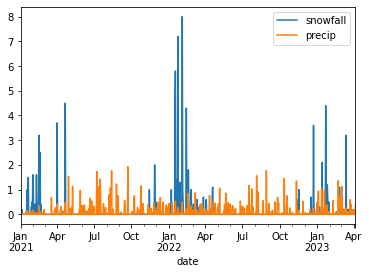

In [122]:
df_weather[['snowfall','precip']].plot();

In [123]:
df_weather = df_weather[['max temp','precip','snowfall']]

In [124]:
df_weather.head()

max temp  precip  snowfall
date                                  
2021-01-01        41    0.84       0.0
2021-01-02        43    0.03       0.0
2021-01-03        41    0.06       0.0
2021-01-04        35    0.03       0.2
2021-01-05        35    0.01       0.0

In [125]:
df_weather.tail()

max temp  precip  snowfall
date                                  
2023-04-01        63    0.16       0.0
2023-04-02        45    0.00       0.0
2023-04-03        68    0.00       0.0
2023-04-04        71    0.00       0.0
2023-04-05        79    0.34       0.0

In [126]:
df_weather.to_csv('data/weather_cleaned.csv')

# Modeling

## Retail First (and Best) Model

In [127]:
df_daily_prophet = df_daily_na.reset_index()

In [128]:
df_daily_prophet.head()

index  pita count
0 2021-01-12         0.2
1 2021-01-13         1.4
2 2021-01-14        47.0
3 2021-01-15        58.8
4 2021-01-16       164.4

In [129]:
df_daily_prophet.rename(columns={'index':'ds','pita count':'y'},inplace=True)

In [130]:
df_daily_prophet.head()

ds      y
0 2021-01-12    0.2
1 2021-01-13    1.4
2 2021-01-14   47.0
3 2021-01-15   58.8
4 2021-01-16  164.4

In [131]:
df_daily_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      791 non-null    datetime64[ns]
 1   y       791 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.5 KB


In [132]:
df_daily_prophet.loc[df_daily_prophet['ds'] == '2023-01-12']

ds     y
730 2023-01-12  33.4

In [133]:
train_full = df_daily_prophet[:731]
test_full = df_daily_prophet[731:]

In [134]:
train_full.tail()

ds     y
726 2023-01-08  18.6
727 2023-01-09  34.0
728 2023-01-10  39.0
729 2023-01-11  21.6
730 2023-01-12  33.4

In [135]:
!pip install fbprophet

In [136]:
import fbprophet

In [137]:
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [138]:
from fbprophet import Prophet

In [139]:
ramadan = pd.DataFrame({
  'holiday': 'ramadan',
  'ds': pd.to_datetime(['2021-04-12','2022-04-01','2023-03-22']),
  'lower_window': 0,
  'upper_window': 29,
})

In [140]:
model = Prophet(holidays=ramadan,changepoint_range=1)
model.add_country_holidays(country_name = 'US')

In [141]:
model.fit(train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [142]:
model.train_holiday_names

0                         ramadan
1                  New Year's Day
2       New Year's Day (Observed)
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7     Independence Day (Observed)
8                       Labor Day
9                    Columbus Day
10                   Veterans Day
11                   Thanksgiving
12                  Christmas Day
13       Christmas Day (Observed)
14        Veterans Day (Observed)
dtype: object

In [143]:
train_dates = pd.DataFrame(train_full['ds'])
train_dates

ds
0   2021-01-12
1   2021-01-13
2   2021-01-14
3   2021-01-15
4   2021-01-16
..         ...
726 2023-01-08
727 2023-01-09
728 2023-01-10
729 2023-01-11
730 2023-01-12

[731 rows x 1 columns]

In [144]:
train_forecast = model.predict(train_dates)

In [145]:
print(train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2021-01-12   36.886079    7.962898   65.971611
1 2021-01-13   52.763821   24.842235   82.927893
2 2021-01-14   48.506941   20.427470   76.357331
3 2021-01-15   53.043936   23.479147   81.732035
4 2021-01-16  102.582697   74.572410  131.855498


In [146]:
train_retail = train_full.merge(train_forecast[['ds','yhat']],on='ds')

In [147]:
train_retail.to_csv('data/train_retail.csv')

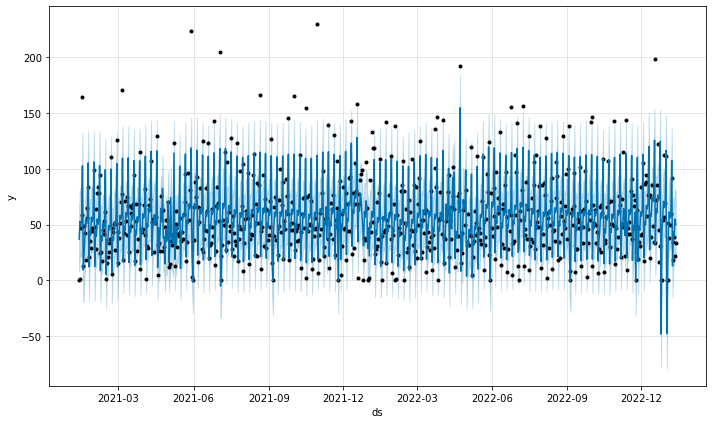

In [148]:
model.plot(train_forecast)
plt.show()

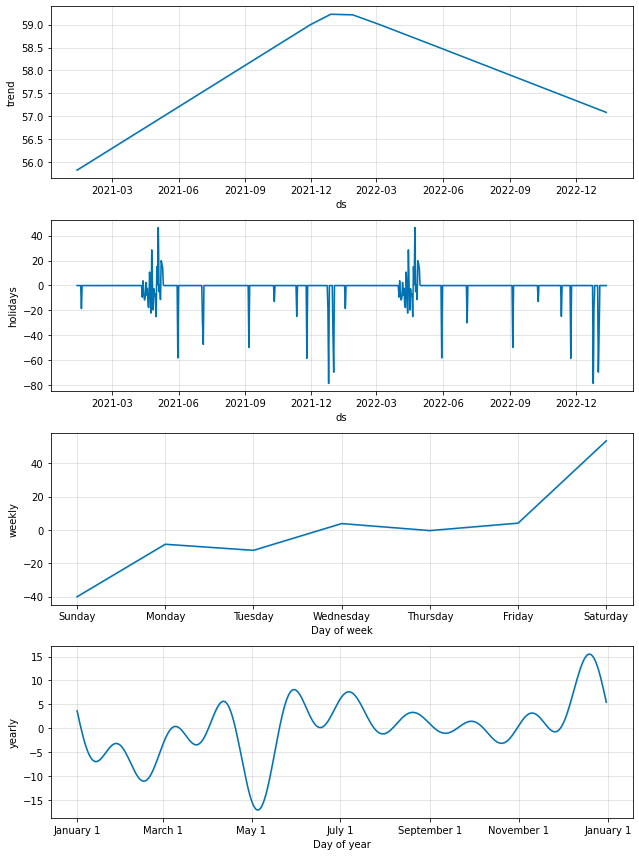

In [149]:
model.plot_components(train_forecast)
plt.show()

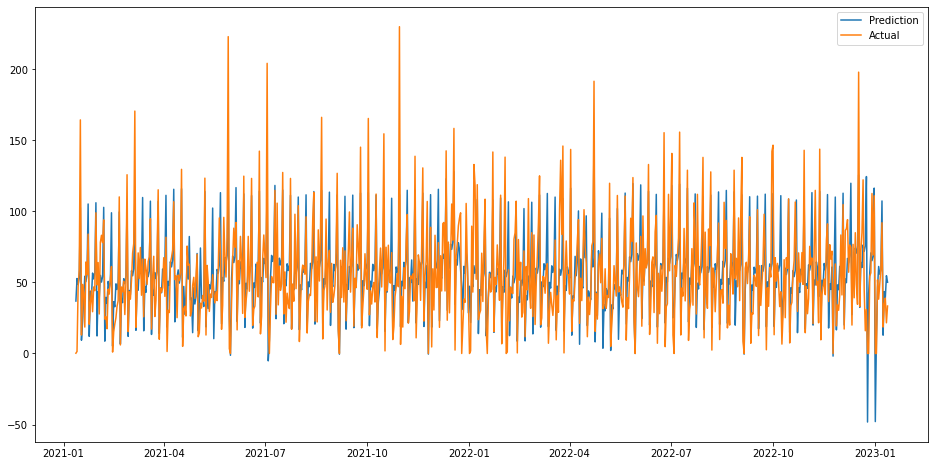

In [150]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(train_full['ds'],train_forecast['yhat'],label='Prediction')
ax.plot(train_full['ds'],train_full['y'],label='Actual')
ax.legend()
plt.show()

In [151]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train_full['y'],train_forecast['yhat'],squared=False)

22.54121117933477

In [152]:
test_dates = pd.DataFrame(test_full['ds'])

In [153]:
test_forecast = model.predict(test_dates)

In [154]:
print(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2023-01-13   54.344984   25.118311   81.740383
1 2023-01-14  103.584724   73.881088  133.167353
2 2023-01-15   10.061598  -19.794843   39.184663
3 2023-01-16   23.184315   -6.746009   51.299419
4 2023-01-17   38.208313    9.021569   67.113470


In [155]:
test_retail = test_full.merge(test_forecast[['ds','yhat']],on='ds')

In [156]:
test_retail.to_csv('data/test_retail.csv')

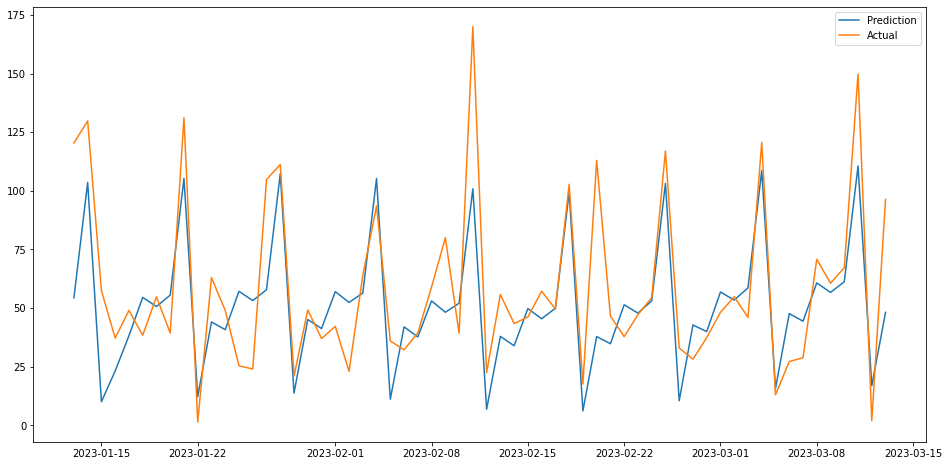

In [157]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_full['ds'],test_forecast['yhat'],label='Prediction')
ax.plot(test_full['ds'],test_full['y'],label='Actual')
ax.legend()
plt.show()

In [158]:
mean_squared_error(test_full['y'],test_forecast['yhat'],squared=False)

24.025850254476524

In [159]:
future = model.make_future_dataframe(periods=353)[790:]
future.head()

ds
790 2023-03-13
791 2023-03-14
792 2023-03-15
793 2023-03-16
794 2023-03-17

In [160]:
future.tail()

ds
1079 2023-12-27
1080 2023-12-28
1081 2023-12-29
1082 2023-12-30
1083 2023-12-31

In [161]:
final_model = Prophet(holidays=ramadan,changepoint_range=1)
final_model.add_country_holidays(country_name = 'US')

In [162]:
final_model.fit(df_daily_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [163]:
future_forecast = final_model.predict(future)

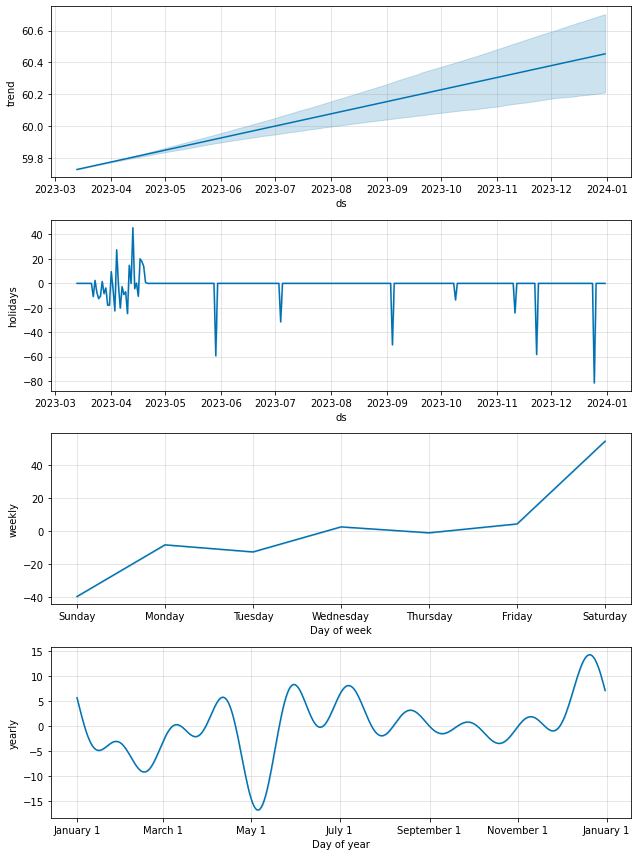

In [164]:
final_model.plot_components(future_forecast)
plt.show()

In [165]:
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-03-13  51.559167   22.557785   78.129851
1 2023-03-14  47.100339   16.651358   76.955422
2 2023-03-15  62.103324   33.749472   91.505352
3 2023-03-16  58.259559   30.560693   86.249755
4 2023-03-17  63.378394   33.137384   90.666872


In [166]:
future_retail = future_forecast[['ds','yhat']]

In [167]:
future_retail.to_csv('data/future_retail.csv')

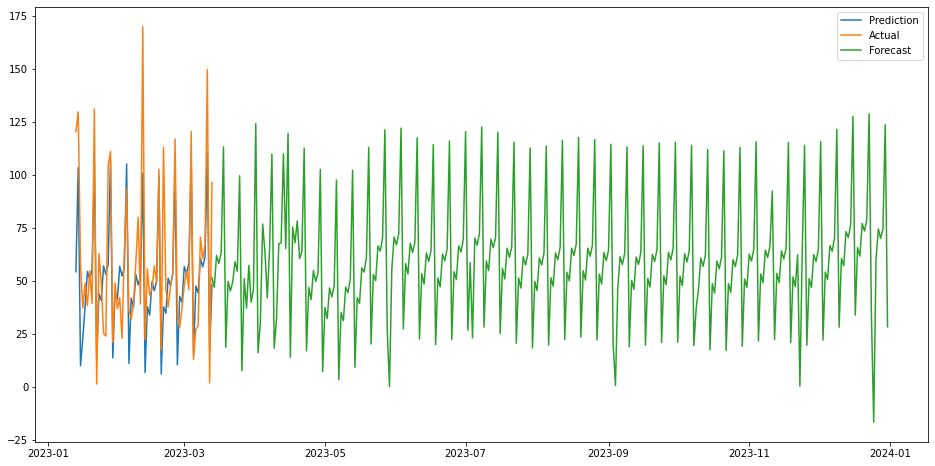

In [168]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_full['ds'],test_forecast['yhat'],label='Prediction')
ax.plot(test_full['ds'],test_full['y'],label='Actual')
ax.plot(future['ds'],future_forecast['yhat'],label='Forecast')
ax.legend()
plt.show()

## Retail Model with Additional Regressors

In [169]:
df_weather_cleaned = pd.read_csv('data/weather_cleaned.csv')

In [170]:
df_weather_cleaned = df_weather_cleaned.rename({'Unnamed: 0': 'date'},axis=1)

In [171]:
df_weather_cleaned['date'] = pd.to_datetime(df_weather_cleaned['date'])
df_weather_cleaned.set_index('date',inplace=True)

In [172]:
df_games = pd.read_csv('data/guards_games.csv')

In [173]:
df_games.head()

Unnamed: 0  Attendance
0  2021-01-01         0.0
1  2021-01-02         0.0
2  2021-01-03         0.0
3  2021-01-04         0.0
4  2021-01-05         0.0

In [174]:
df_games = df_games.rename({'Unnamed: 0': 'date'},axis=1)

In [175]:
df_games['date'] = pd.to_datetime(df_games['date'])
df_games.set_index('date',inplace=True)

In [176]:
df_regressors = pd.concat([df_weather_cleaned,df_games],axis=1)

In [177]:
df_regressors.head()

max temp  precip  snowfall  Attendance
date                                              
2021-01-01      41.0    0.84       0.0         0.0
2021-01-02      43.0    0.03       0.0         0.0
2021-01-03      41.0    0.06       0.0         0.0
2021-01-04      35.0    0.03       0.2         0.0
2021-01-05      35.0    0.01       0.0         0.0

In [178]:
df_regressors.tail()

max temp  precip  snowfall  Attendance
date                                              
2023-12-27       NaN     NaN       NaN         0.0
2023-12-28       NaN     NaN       NaN         0.0
2023-12-29       NaN     NaN       NaN         0.0
2023-12-30       NaN     NaN       NaN         0.0
2023-12-31       NaN     NaN       NaN         0.0

In [179]:
df_regressors = df_regressors['2021-01-12':]
df_regressors.reset_index(inplace=True)

In [180]:
df_regressors = df_regressors.rename({'date':'ds'},axis=1)

In [181]:
df_regressors.head()

ds  max temp  precip  snowfall  Attendance
0 2021-01-12      31.0    0.00       0.0         0.0
1 2021-01-13      47.0    0.00       0.0         0.0
2 2021-01-14      46.0    0.01       0.0         0.0
3 2021-01-15      43.0    0.13       0.1         0.0
4 2021-01-16      34.0    0.01       0.0         0.0

In [182]:
df_modreg = df_daily_prophet.merge(df_regressors,on='ds')

In [183]:
df_modreg.head()

ds      y  max temp  precip  snowfall  Attendance
0 2021-01-12    0.2      31.0    0.00       0.0         0.0
1 2021-01-13    1.4      47.0    0.00       0.0         0.0
2 2021-01-14   47.0      46.0    0.01       0.0         0.0
3 2021-01-15   58.8      43.0    0.13       0.1         0.0
4 2021-01-16  164.4      34.0    0.01       0.0         0.0

In [184]:
df_modreg.tail()

ds      y  max temp  precip  snowfall  Attendance
786 2023-03-09   60.6      40.0    0.00       0.0         0.0
787 2023-03-10   67.2      37.0    0.19       0.2         0.0
788 2023-03-11  149.8      34.0    0.00       0.0         0.0
789 2023-03-12    2.0      37.0    0.00       0.0         0.0
790 2023-03-13   96.4      36.0    0.26       3.2         0.0

In [185]:
train_full = df_modreg[:731]
test_full = df_modreg[731:]

In [186]:
test_dates = test_full.drop('y',axis=1)

In [187]:
param_grid = {  
'changepoint_prior_scale': [0.005, 0.05, 0.5],
'seasonality_prior_scale': [0.1, 1.0, 10.0],
'holidays_prior_scale': [0.1, 1.0, 10.0],
'n_changepoints': [20,25,30],
'changepoint_range': [1],
'holidays': [ramadan],
}

In [188]:
import itertools

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
#for params in all_params:
#    model = Prophet(**params,daily_seasonality=False)
#    model.add_country_holidays(country_name = 'US')
#    model.add_regressor('max temp')
#    model.add_regressor('precip')
#    model.add_regressor('snowfall')
#    model.add_regressor('Attendance')
#    model.fit(train_full)  # Fit model with given params
#    test_forecast = model.predict(test_dates)
#    rmse = mean_squared_error(test_full['y'],test_forecast['yhat'],squared=False)
#    rmses.append(rmse)

# Find the best parameters
#tuning_results = pd.DataFrame(all_params)
#tuning_results['rmse'] = rmses
#print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

In [189]:
model = Prophet(holidays=ramadan,changepoint_range = 1)
model.add_country_holidays(country_name = 'US')
model.add_regressor('max temp')
model.add_regressor('precip')
model.add_regressor('snowfall')
model.add_regressor('Attendance')

In [190]:
model.fit(train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [191]:
train_dates = train_full.drop('y',axis=1)
train_dates

ds  max temp  precip  snowfall  Attendance
0   2021-01-12      31.0    0.00       0.0         0.0
1   2021-01-13      47.0    0.00       0.0         0.0
2   2021-01-14      46.0    0.01       0.0         0.0
3   2021-01-15      43.0    0.13       0.1         0.0
4   2021-01-16      34.0    0.01       0.0         0.0
..         ...       ...     ...       ...         ...
726 2023-01-08      37.0    0.00       0.0         0.0
727 2023-01-09      36.0    0.00       0.0         0.0
728 2023-01-10      44.0    0.00       0.0         0.0
729 2023-01-11      50.0    0.03       0.0         0.0
730 2023-01-12      48.0    1.03       0.0         0.0

[731 rows x 5 columns]

In [192]:
train_forecast = model.predict(train_dates)

In [193]:
print(train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2021-01-12   37.169370    7.923920   64.949517
1 2021-01-13   53.929572   24.880642   80.307024
2 2021-01-14   50.579376   22.437595   78.541819
3 2021-01-15   54.306602   24.064964   82.582865
4 2021-01-16  104.472764   76.847196  133.725441


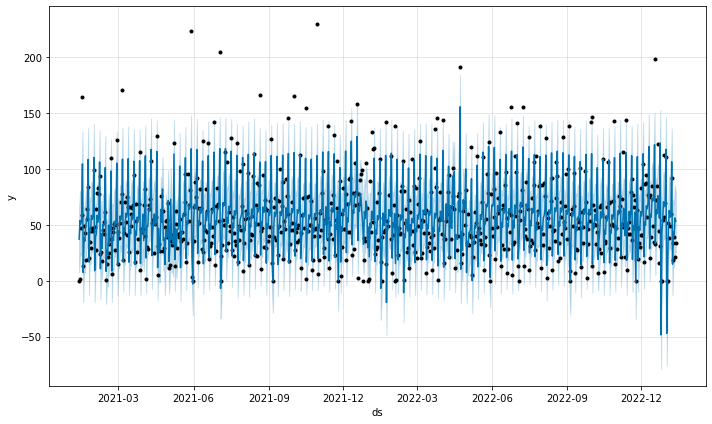

In [194]:
model.plot(train_forecast)
plt.show()

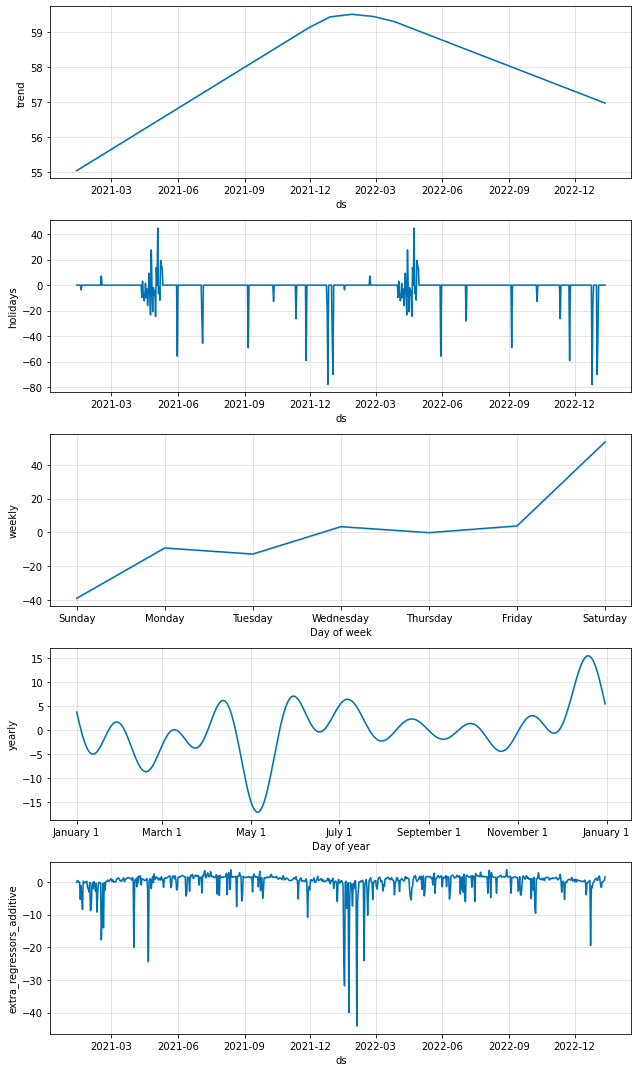

In [195]:
model.plot_components(train_forecast)
plt.show()

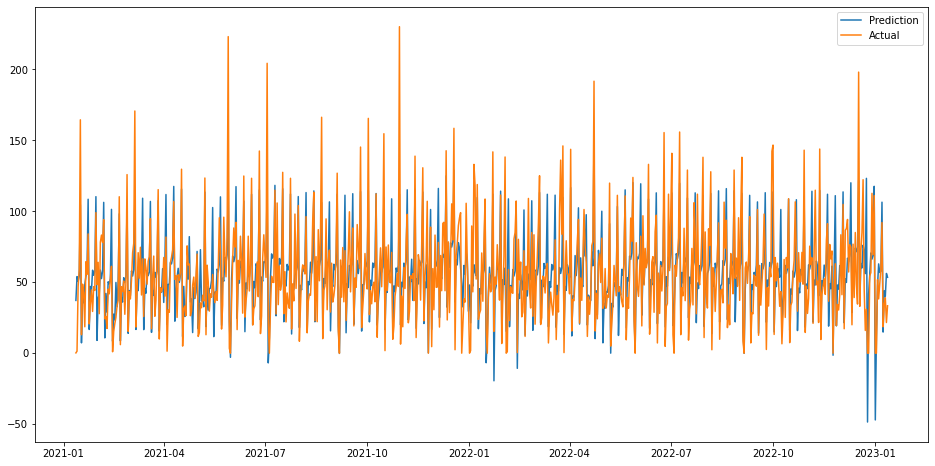

In [196]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(train_full['ds'],train_forecast['yhat'],label='Prediction')
ax.plot(train_full['ds'],train_full['y'],label='Actual')
ax.legend()
plt.show()

In [197]:
mean_squared_error(train_full['y'],train_forecast['yhat'],squared=False)

22.291642574711304

In [198]:
test_dates = test_full.drop('y',axis=1)

In [199]:
test_forecast = model.predict(test_dates)

In [200]:
print(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2023-01-13   44.562057   16.072888   71.985593
1 2023-01-14  105.348846   78.098274  133.235854
2 2023-01-15   13.444687  -15.282385   39.535849
3 2023-01-16   40.435176   11.405292   68.730777
4 2023-01-17   41.068455   14.351490   73.918657


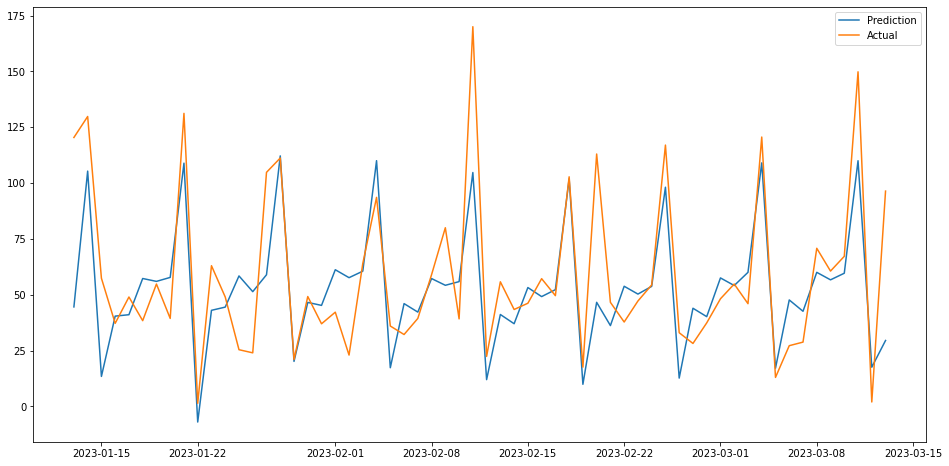

In [201]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_full['ds'],test_forecast['yhat'],label='Prediction')
ax.plot(test_full['ds'],test_full['y'],label='Actual')
ax.legend()
plt.show()

In [202]:
mean_squared_error(test_full['y'],test_forecast['yhat'],squared=False)

24.33647200724268

In [203]:
from fbprophet.utilities import regressor_coefficients

In [204]:
regressor_coefficients(model)

regressor regressor_mode       center  coef_lower      coef  coef_upper
0    max temp       additive    61.414501    0.034086  0.034086    0.034086
1      precip       additive     0.115650    1.091847  1.091847    1.091847
2    snowfall       additive     0.119973   -5.554334 -5.554334   -5.554334
3  Attendance       additive  1289.664843   -0.000293 -0.000293   -0.000293

## Wholesale First (and Best) Model

In [205]:
df_ws_daily_prophet = df_ws_daily_na.reset_index()

In [206]:
df_ws_daily_prophet.head()

index  pita count
0 2021-01-12         1.0
1 2021-01-13         0.0
2 2021-01-14        30.0
3 2021-01-15        12.0
4 2021-01-16         0.0

In [207]:
df_ws_daily_prophet.rename(columns={'index':'ds','pita count':'y'},inplace=True)

In [208]:
df_ws_daily_prophet.head()

ds     y
0 2021-01-12   1.0
1 2021-01-13   0.0
2 2021-01-14  30.0
3 2021-01-15  12.0
4 2021-01-16   0.0

In [209]:
df_ws_daily_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      791 non-null    datetime64[ns]
 1   y       791 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.5 KB


In [210]:
df_ws_daily_prophet.loc[df_ws_daily_prophet['ds'] == '2023-01-12']

ds     y
730 2023-01-12  30.0

In [211]:
ws_train_full = df_ws_daily_prophet[:731]
ws_test_full = df_ws_daily_prophet[731:]

In [212]:
ws_train_full.tail()

ds     y
726 2023-01-08   0.0
727 2023-01-09  73.0
728 2023-01-10  20.0
729 2023-01-11  35.0
730 2023-01-12  30.0

In [213]:
ws_model = Prophet(holidays=ramadan,changepoint_range=1)
ws_model.add_country_holidays(country_name = 'US')

In [214]:
ws_model.fit(ws_train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [215]:
ws_model.train_holiday_names

0                         ramadan
1                  New Year's Day
2       New Year's Day (Observed)
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7     Independence Day (Observed)
8                       Labor Day
9                    Columbus Day
10                   Veterans Day
11                   Thanksgiving
12                  Christmas Day
13       Christmas Day (Observed)
14        Veterans Day (Observed)
dtype: object

In [216]:
ws_train_dates = pd.DataFrame(ws_train_full['ds'])
ws_train_dates

ds
0   2021-01-12
1   2021-01-13
2   2021-01-14
3   2021-01-15
4   2021-01-16
..         ...
726 2023-01-08
727 2023-01-09
728 2023-01-10
729 2023-01-11
730 2023-01-12

[731 rows x 1 columns]

In [217]:
ws_train_forecast = ws_model.predict(train_dates)

In [218]:
print(ws_train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2021-01-12  -9.109184  -28.371711   11.064671
1 2021-01-13   9.124055  -11.781778   29.273861
2 2021-01-14   9.601794   -9.428440   30.841112
3 2021-01-15  14.836827   -5.577900   34.616662
4 2021-01-16  -1.113383  -20.936922   19.290081


In [219]:
train_wholesale = ws_train_full.merge(ws_train_forecast[['ds','yhat']],on='ds')

In [220]:
train_wholesale.to_csv('data/train_wholesale.csv')

In [221]:
train_wholesale.tail()

ds     y       yhat
726 2023-01-08   0.0  16.365128
727 2023-01-09  73.0  32.909169
728 2023-01-10  20.0  18.349431
729 2023-01-11  35.0  36.471759
730 2023-01-12  30.0  36.867666

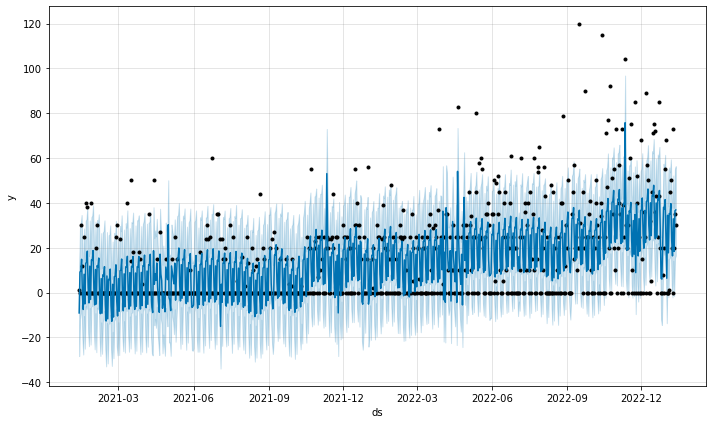

In [222]:
ws_model.plot(ws_train_forecast)
plt.show()

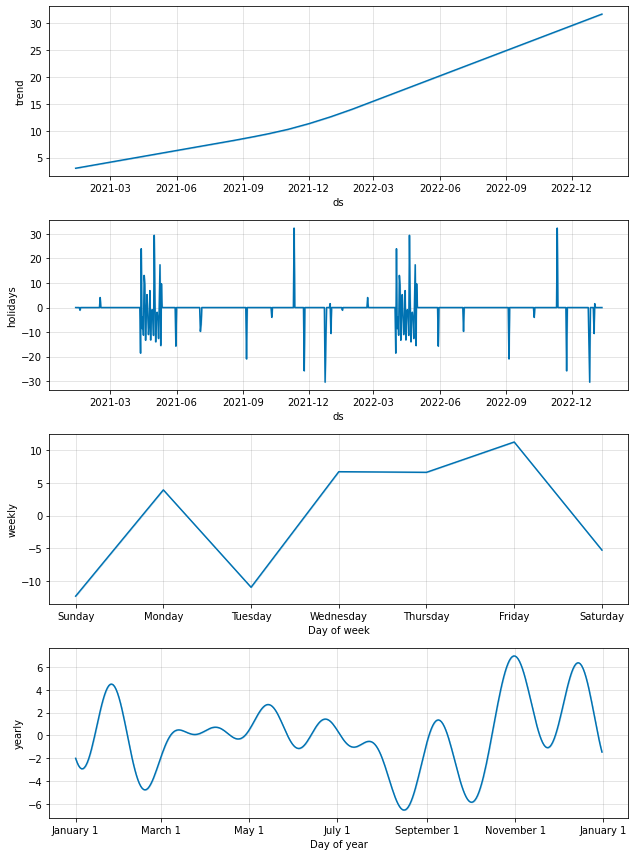

In [223]:
ws_model.plot_components(ws_train_forecast)
plt.show()

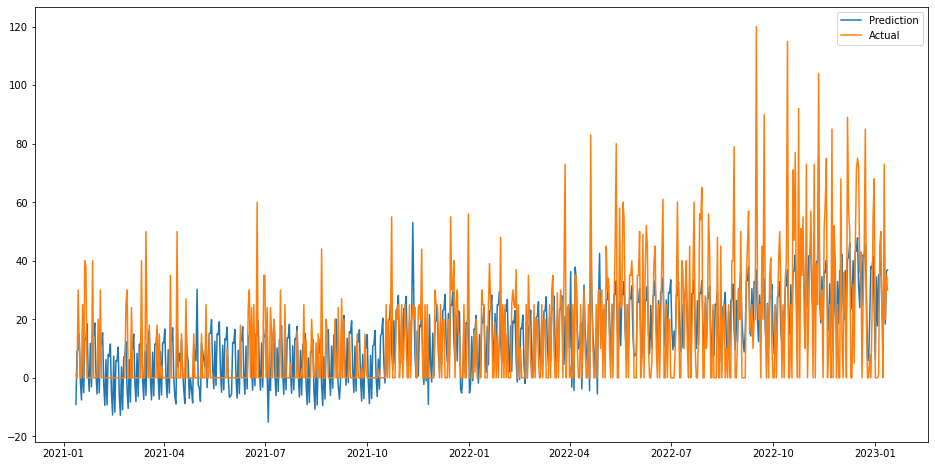

In [224]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_train_full['ds'],ws_train_forecast['yhat'],label='Prediction')
ax.plot(ws_train_full['ds'],ws_train_full['y'],label='Actual')
ax.legend()
plt.show()

In [225]:
mean_squared_error(ws_train_full['y'],ws_train_forecast['yhat'],squared=False)

15.322981447198408

In [226]:
ws_test_dates = pd.DataFrame(ws_test_full['ds'])

In [227]:
ws_test_forecast = ws_model.predict(ws_test_dates)

In [228]:
print(ws_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-01-13  42.052362   23.783110   60.821043
1 2023-01-14  26.085002    6.217180   47.003106
2 2023-01-15  19.642269    0.929025   39.245425
3 2023-01-16  35.425090   15.830573   55.804186
4 2023-01-17  22.253840    2.882218   41.692808


In [229]:
test_wholesale = ws_test_full.merge(ws_test_forecast[['ds','yhat']],on='ds')

In [230]:
test_wholesale.to_csv('data/test_wholesale.csv')

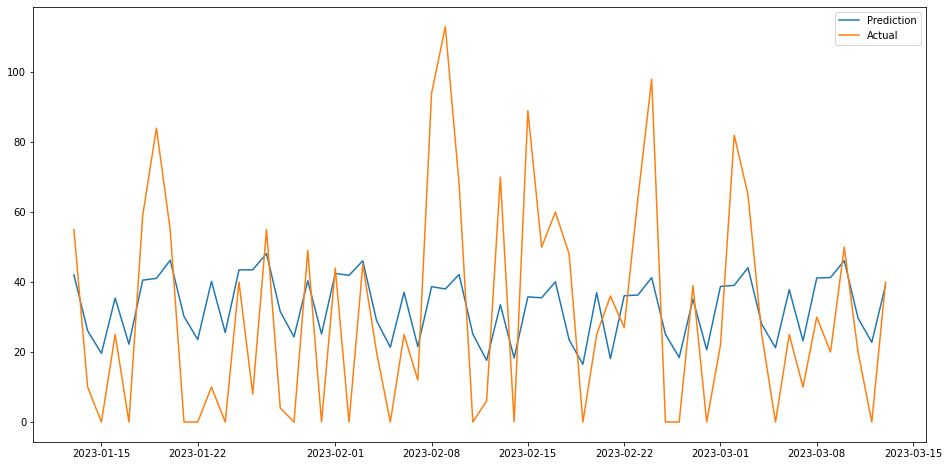

In [231]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_test_full['ds'],ws_test_forecast['yhat'],label='Prediction')
ax.plot(ws_test_full['ds'],ws_test_full['y'],label='Actual')
ax.legend()
plt.show()

In [232]:
mean_squared_error(ws_test_full['y'],ws_test_forecast['yhat'],squared=False)

25.568404254274853

In [233]:
ws_future = ws_model.make_future_dataframe(periods=353)[790:]
ws_future.head()

ds
790 2023-03-13
791 2023-03-14
792 2023-03-15
793 2023-03-16
794 2023-03-17

In [234]:
ws_future.tail()

ds
1079 2023-12-27
1080 2023-12-28
1081 2023-12-29
1082 2023-12-30
1083 2023-12-31

In [235]:
ws_final_model = Prophet(holidays=ramadan,changepoint_range=1)
ws_final_model.add_country_holidays(country_name = 'US')

In [236]:
ws_final_model.fit(df_ws_daily_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [237]:
ws_future_forecast = ws_final_model.predict(ws_future)

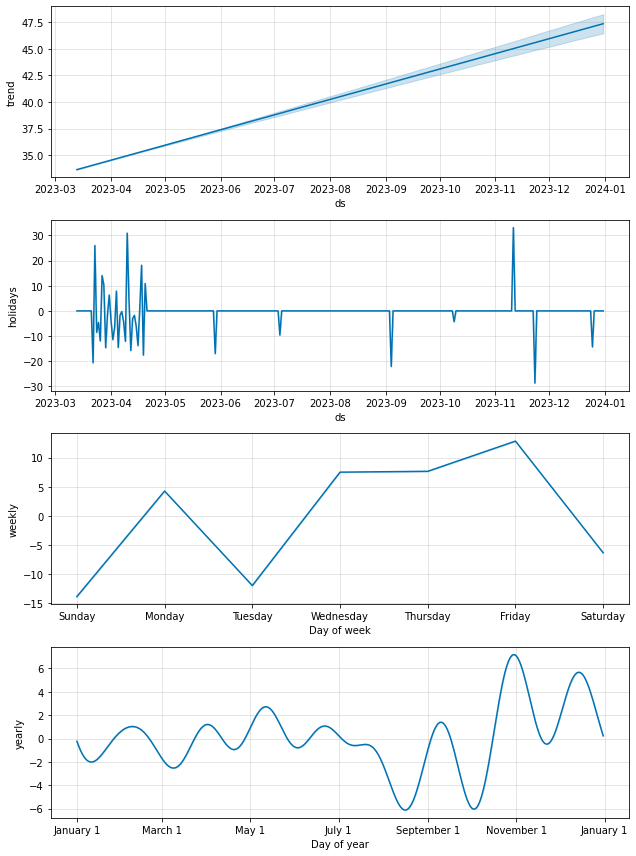

In [238]:
ws_final_model.plot_components(ws_future_forecast)
plt.show()

In [239]:
print(ws_future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-03-13  35.587616   14.451347   57.046942
1 2023-03-14  19.510643   -0.605741   40.073460
2 2023-03-15  39.210965   18.559039   60.310640
3 2023-03-16  39.578918   19.435176   59.433891
4 2023-03-17  45.019039   24.559325   66.286295


In [240]:
future_wholesale = ws_future_forecast[['ds','yhat']]

In [241]:
future_wholesale.to_csv('data/future_wholesale.csv')

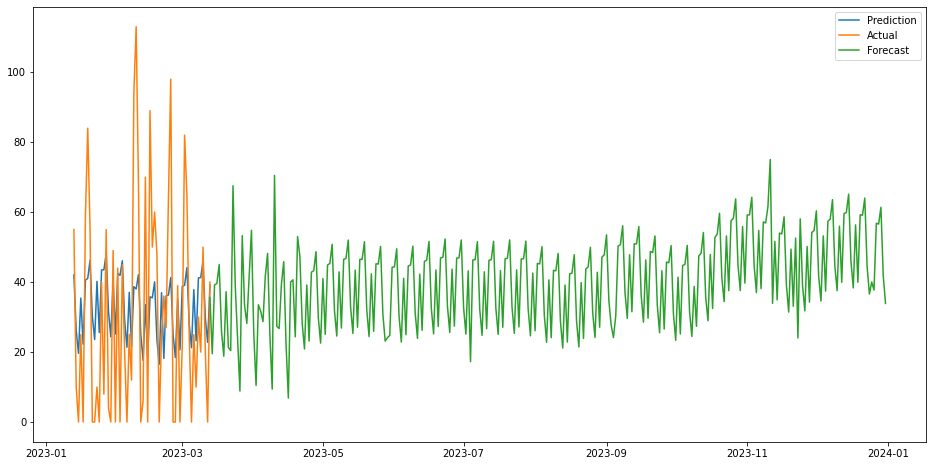

In [242]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_test_full['ds'],ws_test_forecast['yhat'],label='Prediction')
ax.plot(ws_test_full['ds'],ws_test_full['y'],label='Actual')
ax.plot(ws_future['ds'],ws_future_forecast['yhat'],label='Forecast')
ax.legend()
plt.show()

## Wholesale Model with Additional Regressors

In [243]:
df_ws_modreg = df_ws_daily_prophet.merge(df_regressors,on='ds')

In [244]:
df_ws_modreg.head()

ds     y  max temp  precip  snowfall  Attendance
0 2021-01-12   1.0      31.0    0.00       0.0         0.0
1 2021-01-13   0.0      47.0    0.00       0.0         0.0
2 2021-01-14  30.0      46.0    0.01       0.0         0.0
3 2021-01-15  12.0      43.0    0.13       0.1         0.0
4 2021-01-16   0.0      34.0    0.01       0.0         0.0

In [245]:
df_ws_modreg.tail()

ds     y  max temp  precip  snowfall  Attendance
786 2023-03-09  20.0      40.0    0.00       0.0         0.0
787 2023-03-10  50.0      37.0    0.19       0.2         0.0
788 2023-03-11  20.0      34.0    0.00       0.0         0.0
789 2023-03-12   0.0      37.0    0.00       0.0         0.0
790 2023-03-13  40.0      36.0    0.26       3.2         0.0

In [246]:
ws_train_full = df_ws_modreg[:731]
ws_test_full = df_ws_modreg[731:]

In [247]:
ws_test_dates = ws_test_full.drop('y',axis=1)

In [248]:
import itertools

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
#for params in all_params:
#    ws_model = Prophet(**params,daily_seasonality=False)
#    ws_model.add_country_holidays(country_name = 'US')
#    ws_model.add_regressor('max temp')
#    ws_model.add_regressor('precip')
#    ws_model.add_regressor('snowfall')
#    ws_model.add_regressor('Attendance')
#    ws_model.fit(ws_train_full)  # Fit model with given params
#    ws_test_forecast = ws_model.predict(ws_test_dates)
#    rmse = mean_squared_error(ws_test_full['y'],ws_test_forecast['yhat'],squared=False)
#    rmses.append(rmse)

# Find the best parameters
#tuning_results = pd.DataFrame(all_params)
#tuning_results['rmse'] = rmses
#print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

In [249]:
ws_model = Prophet(holidays=ramadan,changepoint_range = 1)
ws_model.add_country_holidays(country_name = 'US')
ws_model.add_regressor('max temp')
ws_model.add_regressor('precip')
ws_model.add_regressor('snowfall')
ws_model.add_regressor('Attendance')

In [250]:
ws_model.fit(ws_train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [251]:
ws_train_dates = ws_train_full.drop('y',axis=1)
ws_train_dates

ds  max temp  precip  snowfall  Attendance
0   2021-01-12      31.0    0.00       0.0         0.0
1   2021-01-13      47.0    0.00       0.0         0.0
2   2021-01-14      46.0    0.01       0.0         0.0
3   2021-01-15      43.0    0.13       0.1         0.0
4   2021-01-16      34.0    0.01       0.0         0.0
..         ...       ...     ...       ...         ...
726 2023-01-08      37.0    0.00       0.0         0.0
727 2023-01-09      36.0    0.00       0.0         0.0
728 2023-01-10      44.0    0.00       0.0         0.0
729 2023-01-11      50.0    0.03       0.0         0.0
730 2023-01-12      48.0    1.03       0.0         0.0

[731 rows x 5 columns]

In [252]:
ws_train_forecast = ws_model.predict(ws_train_dates)

In [253]:
print(ws_train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2021-01-12  -8.266500  -28.293236    9.775733
1 2021-01-13   9.554951   -9.610879   28.977404
2 2021-01-14  10.023447   -9.424217   28.882243
3 2021-01-15  15.125025   -4.820903   35.412468
4 2021-01-16  -0.866524  -20.693358   19.424641


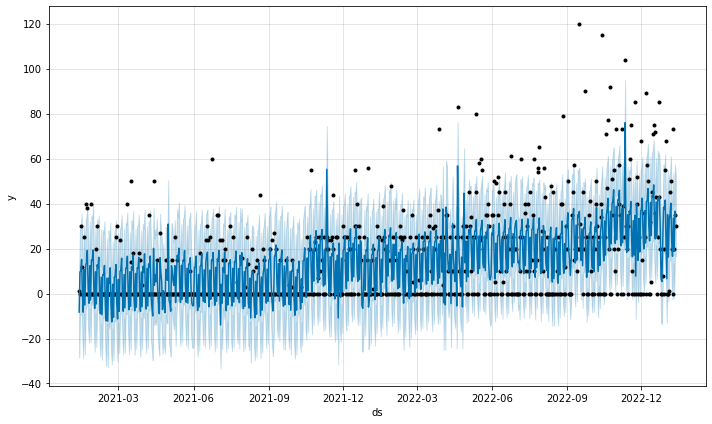

In [254]:
ws_model.plot(ws_train_forecast)
plt.show()

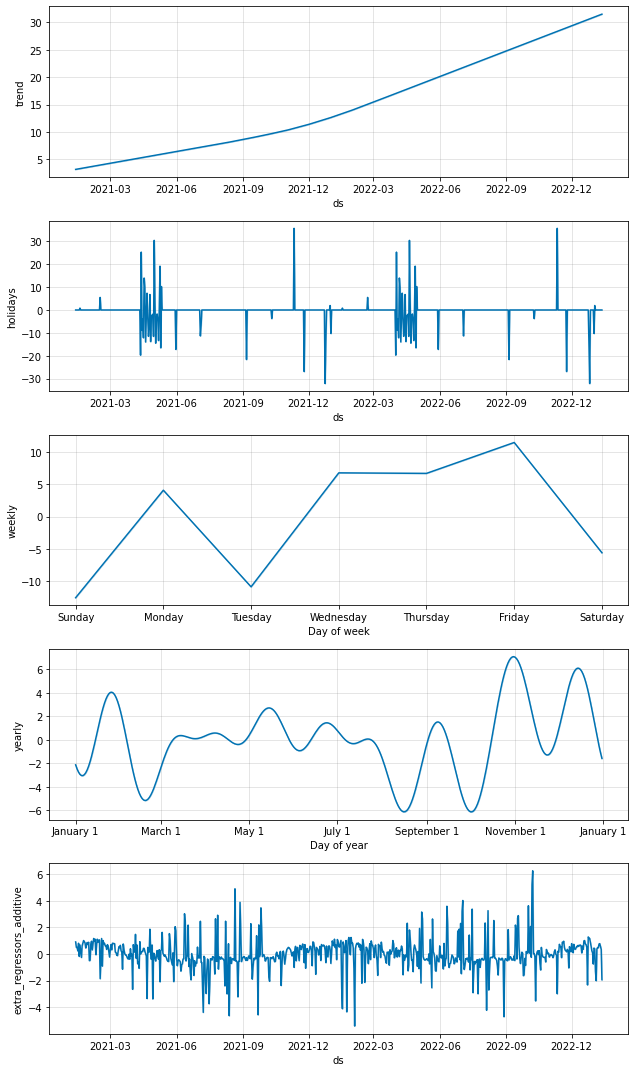

In [255]:
ws_model.plot_components(ws_train_forecast)
plt.show()

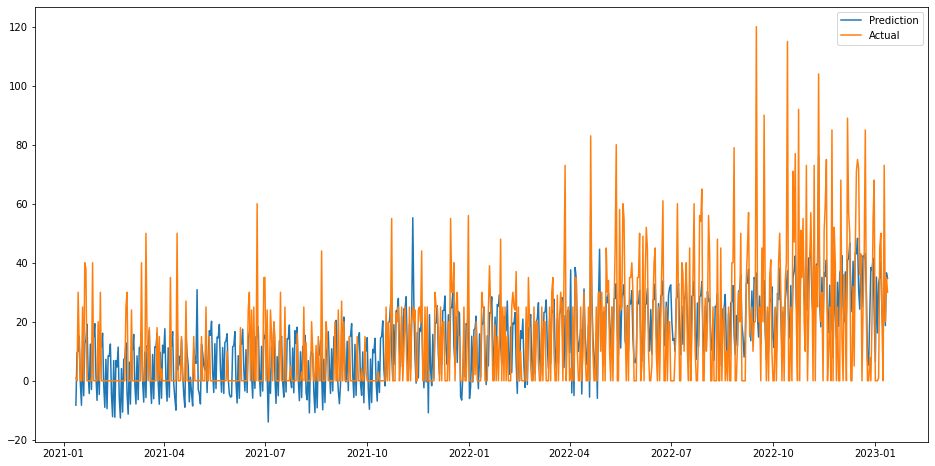

In [256]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_train_full['ds'],ws_train_forecast['yhat'],label='Prediction')
ax.plot(ws_train_full['ds'],ws_train_full['y'],label='Actual')
ax.legend()
plt.show()

In [257]:
mean_squared_error(ws_train_full['y'],ws_train_forecast['yhat'],squared=False)

15.288962790330173

In [258]:
ws_test_dates = ws_test_full.drop('y',axis=1)

In [259]:
ws_test_forecast = ws_model.predict(ws_test_dates)

In [260]:
print(ws_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-01-13  40.550138   21.771431   58.537361
1 2023-01-14  26.315588    6.601652   46.358362
2 2023-01-15  19.732088    0.715825   40.152338
3 2023-01-16  37.090738   19.197536   58.090121
4 2023-01-17  22.091348    3.387914   39.985735


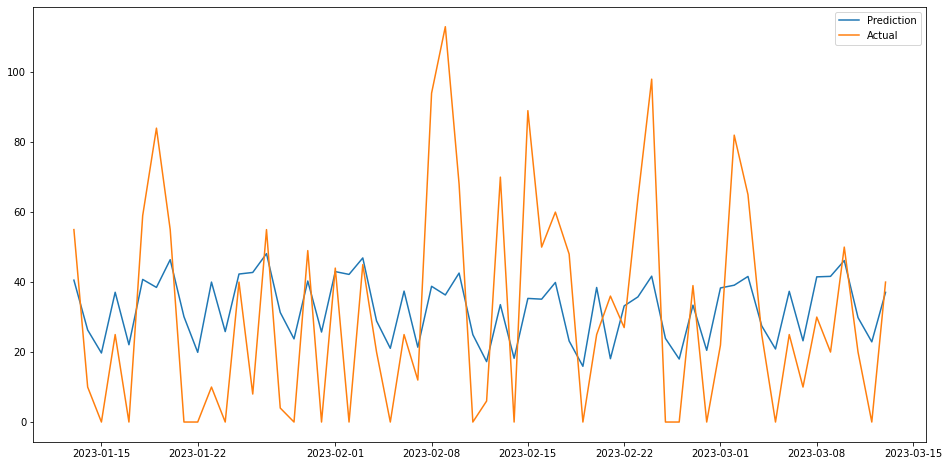

In [261]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_test_full['ds'],ws_test_forecast['yhat'],label='Prediction')
ax.plot(ws_test_full['ds'],ws_test_full['y'],label='Actual')
ax.legend()
plt.show()

In [262]:
mean_squared_error(ws_test_full['y'],ws_test_forecast['yhat'],squared=False)

25.68822370604737

In [263]:
regressor_coefficients(ws_model)

regressor regressor_mode       center  coef_lower      coef  coef_upper
0    max temp       additive    61.414501   -0.025688 -0.025688   -0.025688
1      precip       additive     0.115650   -2.332099 -2.332099   -2.332099
2    snowfall       additive     0.119973   -0.656241 -0.656241   -0.656241
3  Attendance       additive  1289.664843    0.000170  0.000170    0.000170

# Evaluation

In [264]:
df_orders = pd.read_csv('data/orders.csv')

In [265]:
df_orders.head()

Cust ID  Order Number Invoice Date Delivery Date Route  Amount  \
0  01GIA3        739126   01/06/2021    01/06/2021     7  4891.2   
1  01GIA3        739126   01/06/2021    01/06/2021     7  4891.2   
2  01GIA3        739126   01/06/2021    01/06/2021     7  4891.2   
3  01GIA3        739126   01/06/2021    01/06/2021     7  4891.2   
4  01GIA3        739126   01/06/2021    01/06/2021     7  4891.2   

  Cust Category Item No                          Description  Price  \
0          WHSL  710010             LARGE THIN PITA 4ct 12cs    1.4   
1          WHSL  710020      LARGE WHOLE WHEAT PITA 4ct 12cs    1.4   
2          WHSL  710030      SMALL MULTI-GRAIN PITA 5ct 12cs    1.4   
3          WHSL  710050  GARDEN VEGETABLE FLAT WRAPS 4ct 12c    1.4   
4          WHSL  710080        MD GARLIC NAAN 14oz 5ct 24/cs    1.5   

   Qty Order  Qty Delivery  Qty Return  Ext Price  
0     1728.0        1728.0         0.0     2419.2  
1      288.0         288.0         0.0      403.2  
2      360.0         360.0         0.0      504.0  
3      432.0         432.0         0.0      604.8  
4      840.0         840.0         0.0     1260.0

In [266]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231357 entries, 0 to 231356
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Cust ID        231357 non-null  object 
 1   Order Number   231357 non-null  int64  
 2   Invoice Date   231357 non-null  object 
 3   Delivery Date  231357 non-null  object 
 4   Route          231357 non-null  object 
 5   Amount         231357 non-null  float64
 6   Cust Category  231357 non-null  object 
 7   Item No        231356 non-null  object 
 8   Description    231356 non-null  object 
 9   Price          231356 non-null  float64
 10  Qty Order      231356 non-null  float64
 11  Qty Delivery   231356 non-null  float64
 12  Qty Return     231356 non-null  float64
 13  Ext Price      231356 non-null  float64
dtypes: float64(6), int64(1), object(7)
memory usage: 24.7+ MB


In [267]:
df_orders = df_orders.loc[df_orders['Route'] == '9']

In [268]:
df_orders.head()

Cust ID  Order Number Invoice Date Delivery Date Route  Amount  \
55  01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
56  01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
57  01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
58  01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
59  01ALAD        739451   01/06/2021    01/06/2021     9   605.9   

   Cust Category Item No               Description  Price  Qty Order  \
55          WHSL  101510    LG PLAIN 10.5oz #12670   1.20      108.0   
56          WHSL  102510     SM PLAIN 8.3oz #10590   1.05      160.0   
57          WHSL  102520     SM WHEAT 8.3oz #10672   1.10       16.0   
58          WHSL  401040     NAN BREAD 16oz #50005   1.55       54.0   
59          WHSL  601025  BEST BUY LARGE WHEAT 5ct   1.35       36.0   

    Qty Delivery  Qty Return  Ext Price  
55         108.0         0.0      129.6  
56         160.0         0.0      168.0  
57          16.0         0.0       17.6  
58          54.0         0.0       83.7  
59          36.0         0.0       48.6

In [269]:
df_orders['Cust ID'].value_counts()

01ALAD    3976
01FREE       4
Name: Cust ID, dtype: int64

In [270]:
df_orders['Qty Return'].value_counts()

0.0    3980
Name: Qty Return, dtype: int64

In [271]:
df_orders.loc[df_orders['Cust ID'] == '01FREE']

Cust ID  Order Number Invoice Date Delivery Date Route  Amount  \
156062  01FREE        777922   06/17/2022    06/17/2022     9     0.0   
163581  01FREE        779903   07/15/2022    07/15/2022     9     0.0   
185560  01FREE        786043   10/05/2022    10/05/2022     9     0.0   
185681  01FREE        786069   10/06/2022    10/06/2022     9     0.0   

       Cust Category Item No            Description  Price  Qty Order  \
156062          WHSL  401040  NAN BREAD 16oz #50005    0.0      480.0   
163581          WHSL  401040  NAN BREAD 16oz #50005    0.0      480.0   
185560          WHSL  401040  NAN BREAD 16oz #50005    0.0      120.0   
185681          WHSL  401040  NAN BREAD 16oz #50005    0.0      120.0   

        Qty Delivery  Qty Return  Ext Price  
156062         480.0         0.0        0.0  
163581         480.0         0.0        0.0  
185560         120.0         0.0        0.0  
185681         120.0         0.0        0.0

In [272]:
df_orders.loc[df_orders['Invoice Date'] == df_orders['Delivery Date']]

Cust ID  Order Number Invoice Date Delivery Date Route  Amount  \
55      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
56      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
57      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
58      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
59      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
...        ...           ...          ...           ...   ...     ...   
230579  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230580  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230581  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230582  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230583  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   

       Cust Category Item No               Description  Price  Qty Order  \
55              WHSL  101510    LG PLAIN 10.5oz #12670   1.20      108.0   
56              WHSL  102510     SM PLAIN 8.3oz #10590   1.05      160.0   
57              WHSL  102520     SM WHEAT 8.3oz #10672   1.10       16.0   
58              WHSL  401040     NAN BREAD 16oz #50005   1.55       54.0   
59              WHSL  601025  BEST BUY LARGE WHEAT 5ct   1.35       36.0   
...              ...     ...                       ...    ...        ...   
230579          WHSL  101510    LG PLAIN 10.5oz #12670   1.55      126.0   
230580          WHSL  102510     SM PLAIN 8.3oz #10590   1.35       96.0   
230581          WHSL  401040     NAN BREAD 16oz #50005   1.95       18.0   
230582          WHSL  601025  BEST BUY LARGE WHEAT 5ct   1.70       36.0   
230583          WHSL  601615          BEST BUY 9`` 5ct   1.70       90.0   

        Qty Delivery  Qty Return  Ext Price  
55             108.0         0.0      129.6  
56             160.0         0.0      168.0  
57              16.0         0.0       17.6  
58              54.0         0.0       83.7  
59              36.0         0.0       48.6  
...              ...         ...        ...  
230579         126.0         0.0      195.3  
230580          96.0         0.0      129.6  
230581          18.0         0.0       35.1  
230582          36.0         0.0       61.2  
230583          90.0         0.0      153.0  

[3980 rows x 14 columns]

In [273]:
df_orders.loc[df_orders['Qty Order'] == df_orders['Qty Delivery']]

Cust ID  Order Number Invoice Date Delivery Date Route  Amount  \
55      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
56      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
57      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
58      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
59      01ALAD        739451   01/06/2021    01/06/2021     9   605.9   
...        ...           ...          ...           ...   ...     ...   
230579  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230580  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230581  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230582  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   
230583  01ALAD        797945   03/20/2023    03/20/2023     9   574.2   

       Cust Category Item No               Description  Price  Qty Order  \
55              WHSL  101510    LG PLAIN 10.5oz #12670   1.20      108.0   
56              WHSL  102510     SM PLAIN 8.3oz #10590   1.05      160.0   
57              WHSL  102520     SM WHEAT 8.3oz #10672   1.10       16.0   
58              WHSL  401040     NAN BREAD 16oz #50005   1.55       54.0   
59              WHSL  601025  BEST BUY LARGE WHEAT 5ct   1.35       36.0   
...              ...     ...                       ...    ...        ...   
230579          WHSL  101510    LG PLAIN 10.5oz #12670   1.55      126.0   
230580          WHSL  102510     SM PLAIN 8.3oz #10590   1.35       96.0   
230581          WHSL  401040     NAN BREAD 16oz #50005   1.95       18.0   
230582          WHSL  601025  BEST BUY LARGE WHEAT 5ct   1.70       36.0   
230583          WHSL  601615          BEST BUY 9`` 5ct   1.70       90.0   

        Qty Delivery  Qty Return  Ext Price  
55             108.0         0.0      129.6  
56             160.0         0.0      168.0  
57              16.0         0.0       17.6  
58              54.0         0.0       83.7  
59              36.0         0.0       48.6  
...              ...         ...        ...  
230579         126.0         0.0      195.3  
230580          96.0         0.0      129.6  
230581          18.0         0.0       35.1  
230582          36.0         0.0       61.2  
230583          90.0         0.0      153.0  

[3980 rows x 14 columns]

In [274]:
df_orders['Cust Category'].value_counts()

WHSL    3980
Name: Cust Category, dtype: int64

In [275]:
df_orders = df_orders[['Invoice Date','Item No','Description','Price','Qty Order','Ext Price']]

In [276]:
df_orders.head()

Invoice Date Item No               Description  Price  Qty Order  Ext Price
55   01/06/2021  101510    LG PLAIN 10.5oz #12670   1.20      108.0      129.6
56   01/06/2021  102510     SM PLAIN 8.3oz #10590   1.05      160.0      168.0
57   01/06/2021  102520     SM WHEAT 8.3oz #10672   1.10       16.0       17.6
58   01/06/2021  401040     NAN BREAD 16oz #50005   1.55       54.0       83.7
59   01/06/2021  601025  BEST BUY LARGE WHEAT 5ct   1.35       36.0       48.6

In [277]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3980 entries, 55 to 230583
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Invoice Date  3980 non-null   object 
 1   Item No       3980 non-null   object 
 2   Description   3980 non-null   object 
 3   Price         3980 non-null   float64
 4   Qty Order     3980 non-null   float64
 5   Ext Price     3980 non-null   float64
dtypes: float64(3), object(3)
memory usage: 217.7+ KB


In [278]:
df_orders = df_orders.loc[df_orders['Item No'] == '101510']

In [279]:
df_orders.head()

Invoice Date Item No             Description  Price  Qty Order  Ext Price
55     01/06/2021  101510  LG PLAIN 10.5oz #12670    1.2      108.0      129.6
203    01/07/2021  101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2494   01/08/2021  101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2595   01/09/2021  101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2687   01/11/2021  101510  LG PLAIN 10.5oz #12670    1.2       90.0      108.0

In [280]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 55 to 230579
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Invoice Date  566 non-null    object 
 1   Item No       566 non-null    object 
 2   Description   566 non-null    object 
 3   Price         566 non-null    float64
 4   Qty Order     566 non-null    float64
 5   Ext Price     566 non-null    float64
dtypes: float64(3), object(3)
memory usage: 31.0+ KB


In [281]:
df_orders['Invoice Date'] = pd.to_datetime(df_orders['Invoice Date'])

In [282]:
df_orders.set_index('Invoice Date',inplace=True)

In [283]:
df_orders.head(10)

Item No             Description  Price  Qty Order  Ext Price
Invoice Date                                                             
2021-01-06    101510  LG PLAIN 10.5oz #12670    1.2      108.0      129.6
2021-01-07    101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2021-01-08    101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2021-01-09    101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2021-01-11    101510  LG PLAIN 10.5oz #12670    1.2       90.0      108.0
2021-01-13    101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2021-01-14    101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2021-01-15    101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2021-01-16    101510  LG PLAIN 10.5oz #12670    1.2      126.0      151.2
2021-01-18    101510  LG PLAIN 10.5oz #12670    1.2       90.0      108.0

In [284]:
df_orders = pd.DataFrame(df_orders['Qty Order'])

In [285]:
df_orders = df_orders.rename({'Qty Order': 'orders'},axis=1)

In [286]:
df_orders.head(10)

orders
Invoice Date        
2021-01-06     108.0
2021-01-07     126.0
2021-01-08     126.0
2021-01-09     126.0
2021-01-11      90.0
2021-01-13     126.0
2021-01-14     126.0
2021-01-15     126.0
2021-01-16     126.0
2021-01-18      90.0

In [287]:
df_sales = pd.read_csv('data/total_large_white_plain_sales_plus.csv')

df_sales_ex_large = pd.read_csv('data/total_large_white_plain_sales.csv')

In [288]:
df_sales_large = df_sales.merge(df_sales_ex_large,on='date')

In [289]:
df_sales_large.head()

date  retail_sales_x  wholesale_sales_x  total_sales_x  \
0  2021-01-12             0.2                1.0            1.2   
1  2021-01-13             1.4                0.0            1.4   
2  2021-01-14            47.0               30.0           77.0   
3  2021-01-15            58.8               12.0           70.8   
4  2021-01-16           164.4                0.0          164.4   

   retail_sales_y  wholesale_sales_y  total_sales_y  
0             0.2                1.0            1.2  
1             1.4                0.0            1.4  
2            47.0               30.0           77.0  
3            58.8               12.0           70.8  
4           164.4                0.0          164.4

In [290]:
df_sales_large['retail_sales'] = df_sales_large['retail_sales_x'] - df_sales_large['retail_sales_y']
df_sales_large['wholesale_sales'] = df_sales_large['wholesale_sales_x'] - df_sales_large['wholesale_sales_y']
df_sales_large['total_sales'] = df_sales_large['total_sales_x'] - df_sales_large['total_sales_y']

In [291]:
df_sales_large = df_sales_large[['date','retail_sales','wholesale_sales','total_sales']]

In [292]:
df_sales_large.head()

date  retail_sales  wholesale_sales  total_sales
0  2021-01-12           0.0              0.0          0.0
1  2021-01-13           0.0              0.0          0.0
2  2021-01-14           0.0              0.0          0.0
3  2021-01-15           0.0              0.0          0.0
4  2021-01-16           0.0              0.0          0.0

In [293]:
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales.set_index('date',inplace=True)

df_sales_large['date'] = pd.to_datetime(df_sales_large['date'])
df_sales_large.set_index('date',inplace=True)

In [294]:
df_sales.head()

retail_sales  wholesale_sales  total_sales
date                                                  
2021-01-12           0.2              1.0          1.2
2021-01-13           1.4              0.0          1.4
2021-01-14          47.0             30.0         77.0
2021-01-15          58.8             12.0         70.8
2021-01-16         164.4              0.0        164.4

In [295]:
df_sales['day'] = df_sales.index.dayofweek

df_sales_large['day'] = df_sales_large.index.dayofweek

df_orders['day'] = df_orders.index.dayofweek

In [296]:
df_orders.head(10)

orders  day
Invoice Date             
2021-01-06     108.0    2
2021-01-07     126.0    3
2021-01-08     126.0    4
2021-01-09     126.0    5
2021-01-11      90.0    0
2021-01-13     126.0    2
2021-01-14     126.0    3
2021-01-15     126.0    4
2021-01-16     126.0    5
2021-01-18      90.0    0

In [297]:
df_sales['quantity shifted'] = df_sales['total_sales'].shift(-1)

df_sales_large['quantity shifted'] = df_sales_large['total_sales'].shift(-1)

In [298]:
df_sales['new quantity'] = df_sales['total_sales'] + df_sales['quantity shifted']

df_sales_large['new quantity'] = df_sales_large['total_sales'] + df_sales_large['quantity shifted']

In [299]:
df_sales.head(10)

retail_sales  wholesale_sales  total_sales  day  quantity shifted  \
date                                                                            
2021-01-12           0.2              1.0          1.2    1               1.4   
2021-01-13           1.4              0.0          1.4    2              77.0   
2021-01-14          47.0             30.0         77.0    3              70.8   
2021-01-15          58.8             12.0         70.8    4             164.4   
2021-01-16         164.4              0.0        164.4    5              13.0   
2021-01-17          13.0              0.0         13.0    6              73.6   
2021-01-18          48.6             25.0         73.6    0              42.4   
2021-01-19          42.4              0.0         42.4    1             142.6   
2021-01-20         102.6             40.0        142.6    2             102.4   
2021-01-21          64.4             38.0        102.4    3              55.6   

            new quantity  
date                      
2021-01-12           2.6  
2021-01-13          78.4  
2021-01-14         147.8  
2021-01-15         235.2  
2021-01-16         177.4  
2021-01-17          86.6  
2021-01-18         116.0  
2021-01-19         185.0  
2021-01-20         245.0  
2021-01-21         158.0

In [300]:
df_sales = df_sales.loc[(df_sales['day'] != 1) & (df_sales['day'] != 6)]

df_sales_large = df_sales_large.loc[(df_sales_large['day'] != 1) & (df_sales_large['day'] != 6)]

In [301]:
def bake_days(df):
    if df['day'] == 5 or df['day'] == 0:
        return df['new quantity']
    else:
        return df['total_sales']        

In [302]:
df_sales['sales'] = df_sales.apply(bake_days,axis=1)

df_sales_large['large_sales'] = df_sales_large.apply(bake_days,axis=1)

In [303]:
df_sales.head()

retail_sales  wholesale_sales  total_sales  day  quantity shifted  \
date                                                                            
2021-01-13           1.4              0.0          1.4    2              77.0   
2021-01-14          47.0             30.0         77.0    3              70.8   
2021-01-15          58.8             12.0         70.8    4             164.4   
2021-01-16         164.4              0.0        164.4    5              13.0   
2021-01-18          48.6             25.0         73.6    0              42.4   

            new quantity  sales  
date                             
2021-01-13          78.4    1.4  
2021-01-14         147.8   77.0  
2021-01-15         235.2   70.8  
2021-01-16         177.4  177.4  
2021-01-18         116.0  116.0

In [304]:
df_orders.head()

orders  day
Invoice Date             
2021-01-06     108.0    2
2021-01-07     126.0    3
2021-01-08     126.0    4
2021-01-09     126.0    5
2021-01-11      90.0    0

In [305]:
df_so = pd.concat([df_orders['orders'],df_sales['sales']],axis=1).dropna()

In [306]:
df_so_train = df_so[:'2023-01-12']

df_so_test = df_so['2023-01-13':]

In [307]:
df_so_train.head(15)

orders  sales
2021-01-13   126.0    1.4
2021-01-14   126.0   77.0
2021-01-15   126.0   70.8
2021-01-16   126.0  177.4
2021-01-18    90.0  116.0
2021-01-20    90.0  142.6
2021-01-21    90.0  102.4
2021-01-22    90.0   55.6
2021-01-23   126.0  104.6
2021-01-25    90.0   79.4
2021-01-27    90.0   69.4
2021-01-28    90.0   46.8
2021-01-29   108.0   44.2
2021-01-30   126.0  147.2
2021-02-01    90.0  111.8

In [308]:
df_so_train.tail()

orders  sales
2023-01-06   108.0  109.6
2023-01-07   162.0  130.6
2023-01-09   144.0  166.0
2023-01-11   108.0   56.6
2023-01-12   108.0   63.4

In [309]:
df_so_test.head()

orders  sales
2023-01-13   108.0  175.4
2023-01-14   162.0  197.2
2023-01-16   126.0  111.2
2023-01-18   108.0   97.4
2023-01-19   108.0  138.8

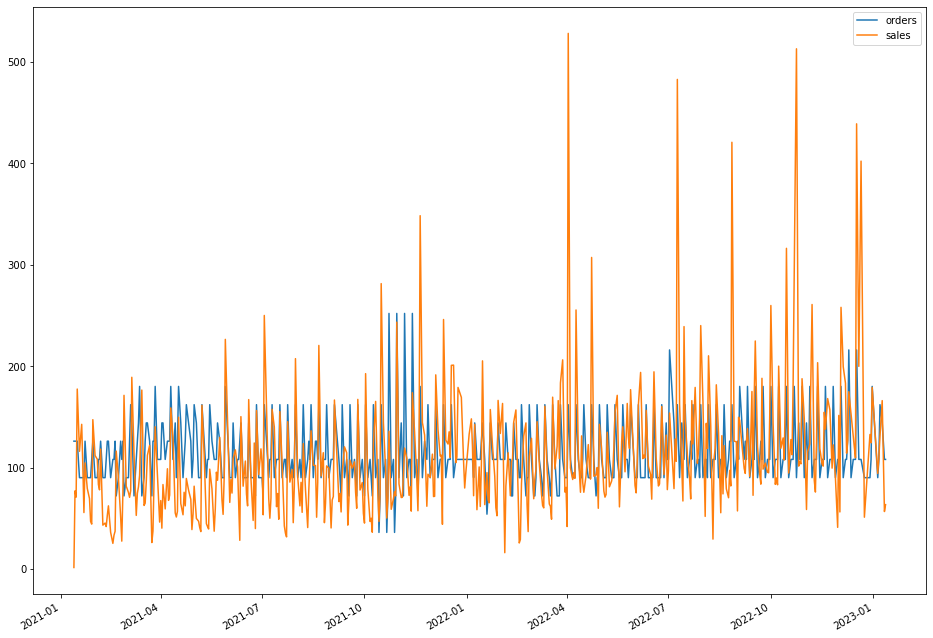

In [310]:
df_so_train.plot(figsize=(16,12));

In [311]:
(((df_so_train['orders'] - df_so_train['sales'])**2).mean())**0.5

58.15039429303678

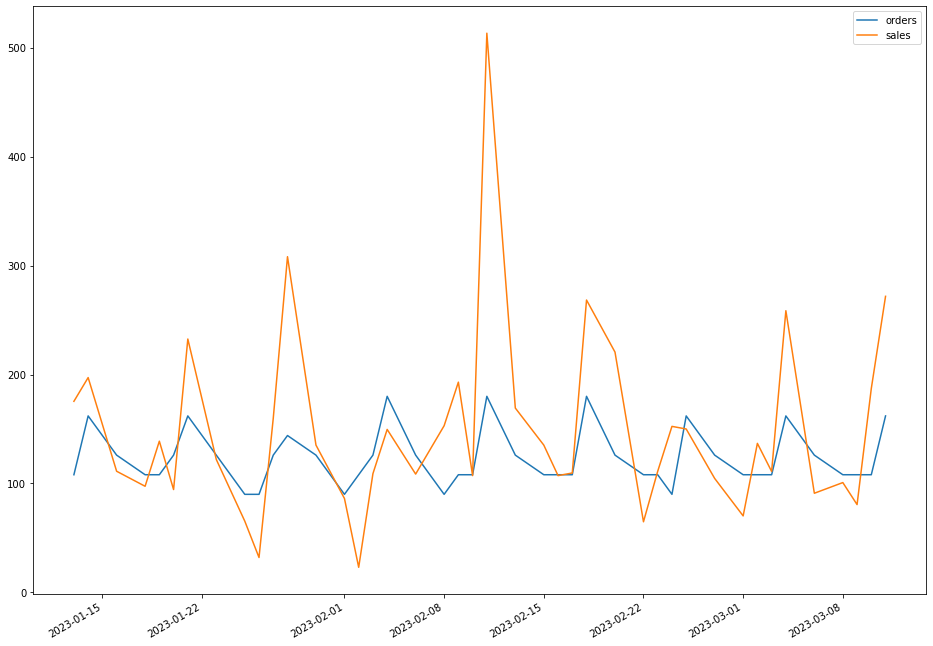

In [312]:
df_so_test.plot(figsize=(16,12));

In [313]:
(((df_so_test['orders'] - df_so_test['sales'])**2).mean())**0.5

74.64591335734588

In [314]:
train_wholesale = pd.read_csv('data/train_wholesale.csv')

test_wholesale = pd.read_csv('data/test_wholesale.csv')

In [315]:
train_retail = pd.read_csv('data/train_retail.csv')

test_retail = pd.read_csv('data/test_retail.csv')

In [316]:
train_wholesale.head()

Unnamed: 0          ds     y       yhat
0           0  2021-01-12   1.0  -9.109184
1           1  2021-01-13   0.0   9.124055
2           2  2021-01-14  30.0   9.601794
3           3  2021-01-15  12.0  14.836827
4           4  2021-01-16   0.0  -1.113383

In [317]:
train_retail.head()

Unnamed: 0          ds      y        yhat
0           0  2021-01-12    0.2   36.886079
1           1  2021-01-13    1.4   52.763821
2           2  2021-01-14   47.0   48.506941
3           3  2021-01-15   58.8   53.043936
4           4  2021-01-16  164.4  102.582697

In [318]:
train_total = train_retail.merge(train_wholesale,on='ds')

test_total = test_retail.merge(test_wholesale,on='ds')

In [319]:
train_total.head()

Unnamed: 0_x          ds    y_x      yhat_x  Unnamed: 0_y   y_y     yhat_y
0             0  2021-01-12    0.2   36.886079             0   1.0  -9.109184
1             1  2021-01-13    1.4   52.763821             1   0.0   9.124055
2             2  2021-01-14   47.0   48.506941             2  30.0   9.601794
3             3  2021-01-15   58.8   53.043936             3  12.0  14.836827
4             4  2021-01-16  164.4  102.582697             4   0.0  -1.113383

In [320]:
train_total = train_total.drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1)
train_total = train_total.rename({'y_x':'y_retail','yhat_x':'yhat_retail','y_y':'y_wholesale','yhat_y':'yhat_wholesale'},axis=1)

test_total = test_total.drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1)
test_total = test_total.rename({'y_x':'y_retail','yhat_x':'yhat_retail','y_y':'y_wholesale','yhat_y':'yhat_wholesale'},axis=1)

In [321]:
train_total.head()

ds  y_retail  yhat_retail  y_wholesale  yhat_wholesale
0  2021-01-12       0.2    36.886079          1.0       -9.109184
1  2021-01-13       1.4    52.763821          0.0        9.124055
2  2021-01-14      47.0    48.506941         30.0        9.601794
3  2021-01-15      58.8    53.043936         12.0       14.836827
4  2021-01-16     164.4   102.582697          0.0       -1.113383

In [322]:
train_total[train_total['yhat_retail'] < 0]

ds  y_retail  yhat_retail  y_wholesale  yhat_wholesale
139  2021-05-31       0.0    -1.274703          0.0       -6.282923
173  2021-07-04      21.8    -5.190655          0.0      -15.124868
237  2021-09-06       0.0    -0.500718          0.0       -7.301574
317  2021-11-25       0.0    -0.433018          0.0       -9.100491
601  2022-09-05       0.0    -0.515151          0.0        8.846735
681  2022-11-24       0.0    -1.853461          0.0        8.894710
712  2022-12-25       0.0   -48.248149          0.0        6.337791
719  2023-01-01       0.0   -47.934303          0.0        6.370416

In [323]:
train_total['yhat_retail'] = np.where(train_total['yhat_retail'] < 0,0,train_total['yhat_retail'])
train_total['yhat_wholesale'] = np.where(train_total['yhat_wholesale'] < 0,0,train_total['yhat_wholesale'])

test_total['yhat_retail'] = np.where(test_total['yhat_retail'] < 0,0,test_total['yhat_retail'])
test_total['yhat_wholesale'] = np.where(test_total['yhat_wholesale'] < 0,0,test_total['yhat_wholesale'])

In [324]:
train_total['y_total'] = train_total['y_retail'] + train_total['y_wholesale']
train_total['yhat_total'] = train_total['yhat_retail'] + train_total['yhat_wholesale']

test_total['y_total'] = test_total['y_retail'] + test_total['y_wholesale']
test_total['yhat_total'] = test_total['yhat_retail'] + test_total['yhat_wholesale']

In [325]:
train_total.head()

ds  y_retail  yhat_retail  y_wholesale  yhat_wholesale  y_total  \
0  2021-01-12       0.2    36.886079          1.0        0.000000      1.2   
1  2021-01-13       1.4    52.763821          0.0        9.124055      1.4   
2  2021-01-14      47.0    48.506941         30.0        9.601794     77.0   
3  2021-01-15      58.8    53.043936         12.0       14.836827     70.8   
4  2021-01-16     164.4   102.582697          0.0        0.000000    164.4   

   yhat_total  
0   36.886079  
1   61.887876  
2   58.108735  
3   67.880764  
4  102.582697

In [326]:
train_total['ds'] = pd.to_datetime(train_total['ds'])
train_total.set_index('ds',inplace=True)

test_total['ds'] = pd.to_datetime(test_total['ds'])
test_total.set_index('ds',inplace=True)

In [327]:
train_total['day'] = train_total.index.dayofweek

test_total['day'] = test_total.index.dayofweek

In [328]:
train_total['quantity shifted'] = train_total['yhat_total'].shift(-1)

test_total['quantity shifted'] = test_total['yhat_total'].shift(-1)

In [329]:
train_total['new quantity'] = train_total['yhat_total'] + train_total['quantity shifted']

test_total['new quantity'] = test_total['yhat_total'] + test_total['quantity shifted']

In [330]:
train_total = train_total.loc[(train_total['day'] != 1) & (train_total['day'] != 6)]

test_total = test_total.loc[(test_total['day'] != 1) & (test_total['day'] != 6)]

In [331]:
def bake_days(df):
    if df['day'] == 5 or df['day'] == 0:
        return df['new quantity']
    else:
        return df['yhat_total']

In [332]:
train_total['predicted_sales'] = train_total.apply(bake_days,axis=1)

test_total['predicted_sales'] = test_total.apply(bake_days,axis=1)

In [333]:
train_total.head(15)

y_retail  yhat_retail  y_wholesale  yhat_wholesale  y_total  \
ds                                                                        
2021-01-13       1.4    52.763821          0.0        9.124055      1.4   
2021-01-14      47.0    48.506941         30.0        9.601794     77.0   
2021-01-15      58.8    53.043936         12.0       14.836827     70.8   
2021-01-16     164.4   102.582697          0.0        0.000000    164.4   
2021-01-18      48.6    22.670841         25.0        8.158514     73.6   
2021-01-20      18.6    54.343266         40.0       13.095455     58.6   
2021-01-21      64.4    50.561915         38.0       13.442029    102.4   
2021-01-22      55.6    55.450849          0.0       18.458195     55.6   
2021-01-23      84.0   105.212769          0.0        2.206659     84.0   
2021-01-25      34.8    43.829534          0.0       11.773419     34.8   
2021-01-27      29.4    56.597276         40.0       14.551494     69.4   
2021-01-28      46.8    52.439187          0.0       14.321120     46.8   
2021-01-29      44.2    56.862777          0.0       18.740886     44.2   
2021-01-30      99.0   106.087407          0.0        1.886853     99.0   
2021-02-01      64.0    43.489076         20.0       10.283479     84.0   

            yhat_total  day  quantity shifted  new quantity  predicted_sales  
ds                                                                            
2021-01-13   61.887876    2         58.108735    119.996612        61.887876  
2021-01-14   58.108735    3         67.880764    125.989499        58.108735  
2021-01-15   67.880764    4        102.582697    170.463461        67.880764  
2021-01-16  102.582697    5          9.323844    111.906541       111.906541  
2021-01-18   30.829355    0         37.875012     68.704368        68.704368  
2021-01-20   67.438721    2         64.003944    131.442665        67.438721  
2021-01-21   64.003944    3         73.909044    137.912988        64.003944  
2021-01-22   73.909044    4        107.419428    181.328472        73.909044  
2021-01-23  107.419428    5         12.046624    119.466052       119.466052  
2021-01-25   55.602954    0         40.402786     96.005740        96.005740  
2021-01-27   71.148770    2         66.760307    137.909077        71.148770  
2021-01-28   66.760307    3         75.603662    142.363969        66.760307  
2021-01-29   75.603662    4        107.974261    183.577923        75.603662  
2021-01-30  107.974261    5         12.330526    120.304787       120.304787  
2021-02-01   53.772555    0         39.424934     93.197489        93.197489

In [334]:
train_total = train_total.merge(df_sales['sales'],left_index=True,right_index=True)

test_total = test_total.merge(df_sales['sales'],left_index=True,right_index=True)

In [335]:
train_total = train_total.merge(df_sales_large['large_sales'],left_index=True,right_index=True)

test_total = test_total.merge(df_sales_large['large_sales'],left_index=True,right_index=True)

In [336]:
train_total.head()

y_retail  yhat_retail  y_wholesale  yhat_wholesale  y_total  \
2021-01-13       1.4    52.763821          0.0        9.124055      1.4   
2021-01-14      47.0    48.506941         30.0        9.601794     77.0   
2021-01-15      58.8    53.043936         12.0       14.836827     70.8   
2021-01-16     164.4   102.582697          0.0        0.000000    164.4   
2021-01-18      48.6    22.670841         25.0        8.158514     73.6   

            yhat_total  day  quantity shifted  new quantity  predicted_sales  \
2021-01-13   61.887876    2         58.108735    119.996612        61.887876   
2021-01-14   58.108735    3         67.880764    125.989499        58.108735   
2021-01-15   67.880764    4        102.582697    170.463461        67.880764   
2021-01-16  102.582697    5          9.323844    111.906541       111.906541   
2021-01-18   30.829355    0         37.875012     68.704368        68.704368   

            sales  large_sales  
2021-01-13    1.4          0.0  
2021-01-14   77.0          0.0  
2021-01-15   70.8          0.0  
2021-01-16  177.4          0.0  
2021-01-18  116.0          0.0

In [337]:
test_total.head()

y_retail  yhat_retail  y_wholesale  yhat_wholesale  y_total  \
2023-01-13     120.4    54.344984         55.0       42.052362    175.4   
2023-01-14     129.8   103.584724         10.0       26.085002    139.8   
2023-01-16      37.2    23.184315         25.0       35.425090     62.2   
2023-01-18      38.4    54.543393         59.0       40.563927     97.4   
2023-01-19      54.8    50.677465         84.0       41.057625    138.8   

            yhat_total  day  quantity shifted  new quantity  predicted_sales  \
2023-01-13   96.397346    4        129.669726    226.067072        96.397346   
2023-01-14  129.669726    5         29.703867    159.373593       159.373593   
2023-01-16   58.609405    0         60.462153    119.071558       119.071558   
2023-01-18   95.107320    2         91.735090    186.842409        95.107320   
2023-01-19   91.735090    3        101.778866    193.513956        91.735090   

            sales  large_sales  
2023-01-13  175.4          0.0  
2023-01-14  197.2          0.0  
2023-01-16  111.2          0.0  
2023-01-18   97.4          0.0  
2023-01-19  138.8          0.0

In [338]:
train_total.tail()

y_retail  yhat_retail  y_wholesale  yhat_wholesale  y_total  \
2023-01-06      59.6    59.048673         50.0       39.689028    109.6   
2023-01-07      92.0   107.349251         20.0       23.233496    112.0   
2023-01-09      34.0    43.555552         73.0       32.909169    107.0   
2023-01-11      21.6    54.741342         35.0       36.471759     56.6   
2023-01-12      33.4    50.135516         30.0       36.867666     63.4   

            yhat_total  day  quantity shifted  new quantity  predicted_sales  \
2023-01-06   98.737701    4        130.582747    229.320448        98.737701   
2023-01-07  130.582747    5         29.248969    159.831716       159.831716   
2023-01-09   76.464721    0         57.575642    134.040363       134.040363   
2023-01-11   91.213102    2         87.003181    178.216283        91.213102   
2023-01-12   87.003181    3               NaN           NaN        87.003181   

            sales  large_sales  
2023-01-06  109.6          0.0  
2023-01-07  130.6          0.0  
2023-01-09  166.0          0.0  
2023-01-11   56.6          0.0  
2023-01-12   63.4          0.0

In [339]:
test_total.tail()

y_retail  yhat_retail  y_wholesale  yhat_wholesale  y_total  \
2023-03-08      70.8    60.724992         30.0       41.170841    100.8   
2023-03-09      60.6    56.686899         20.0       41.295341     80.6   
2023-03-10      67.2    61.219792         50.0       46.119646    117.2   
2023-03-11     149.8   110.549134         20.0       29.716122    169.8   
2023-03-13      96.4    48.169778         40.0       39.132943    136.4   

            yhat_total  day  quantity shifted  new quantity  predicted_sales  \
2023-03-08  101.895833    2         97.982240    199.878073       101.895833   
2023-03-09   97.982240    3        107.339438    205.321678        97.982240   
2023-03-10  107.339438    4        140.265255    247.604693       107.339438   
2023-03-11  140.265255    5         39.674780    179.940035       179.940035   
2023-03-13   87.302721    0               NaN           NaN              NaN   

            sales  large_sales  
2023-03-08  100.8          0.0  
2023-03-09   80.6          0.0  
2023-03-10  187.2         70.0  
2023-03-11  271.8        100.0  
2023-03-13    NaN          NaN

In [340]:
train_total['all_predicted_sales'] = train_total['predicted_sales'] + train_total['large_sales']

test_total['all_predicted_sales'] = test_total['predicted_sales'] + test_total['large_sales']

In [341]:
(((train_total['all_predicted_sales'] - train_total['sales'])**2).mean())**0.5

32.895576732343144

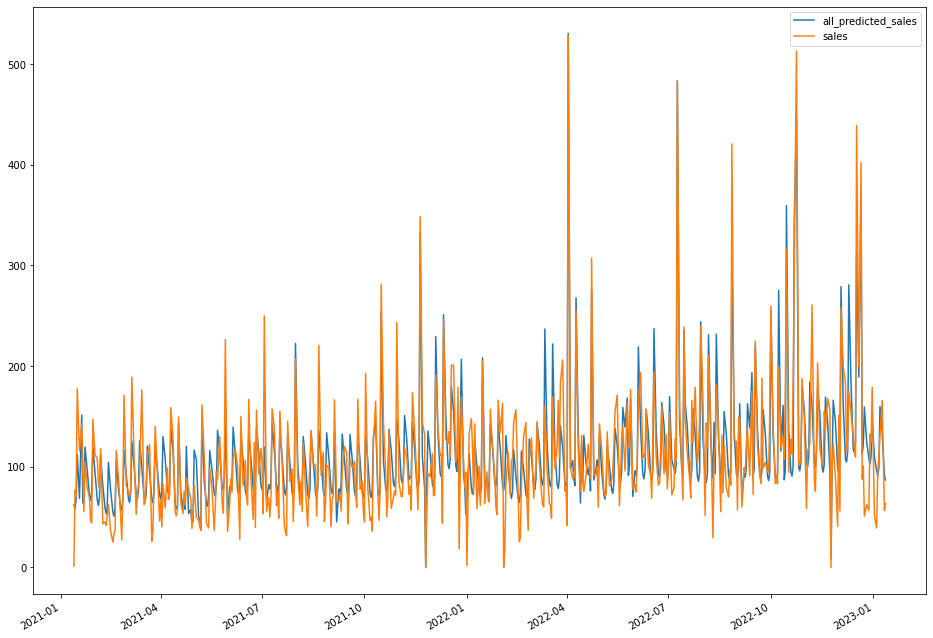

In [342]:
train_total[['all_predicted_sales','sales']].plot(figsize=(16,12));

In [343]:
(((test_total['all_predicted_sales'] - test_total['sales'])**2).mean())**0.5

42.108682000843196

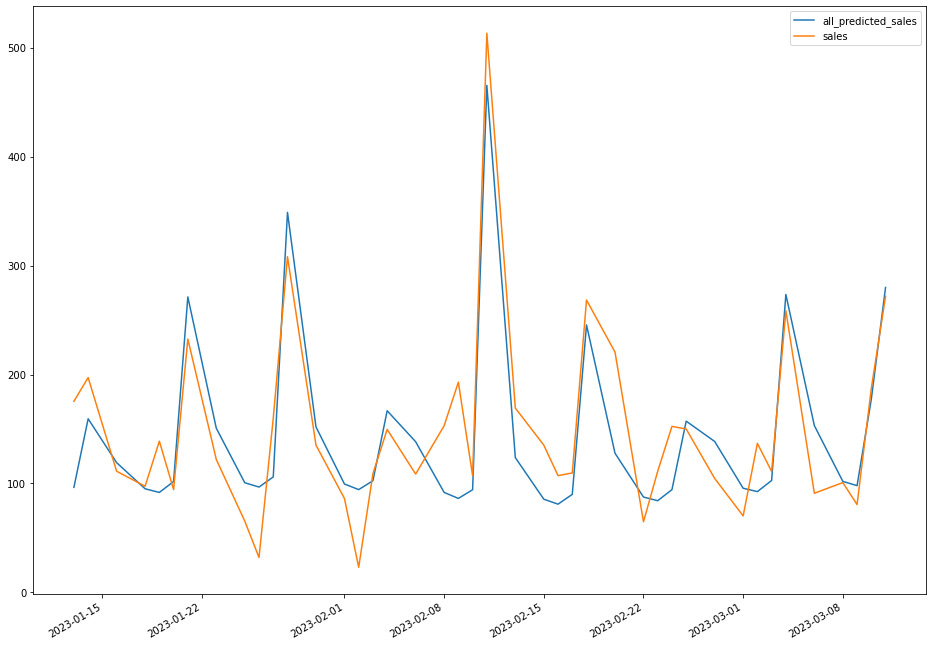

In [344]:
test_total[['all_predicted_sales','sales']].plot(figsize=(16,12));

# Recommendations

In [345]:
future_retail = pd.read_csv('data/future_retail.csv')

future_wholesale = pd.read_csv('data/future_wholesale.csv')

In [346]:
future_retail.head()

Unnamed: 0          ds       yhat
0           0  2023-03-13  51.559167
1           1  2023-03-14  47.100339
2           2  2023-03-15  62.103324
3           3  2023-03-16  58.259559
4           4  2023-03-17  63.378394

In [347]:
future_wholesale.head()

Unnamed: 0          ds       yhat
0           0  2023-03-13  35.587616
1           1  2023-03-14  19.510643
2           2  2023-03-15  39.210965
3           3  2023-03-16  39.578918
4           4  2023-03-17  45.019039

In [348]:
future_retail = future_retail.drop('Unnamed: 0',axis=1)

future_wholesale = future_wholesale.drop('Unnamed: 0',axis=1)

In [349]:
future_retail = future_retail.rename({'ds':'date','yhat':'retail_pred'},axis=1)

future_wholesale = future_wholesale.rename({'ds':'date','yhat':'wholesale_pred'},axis=1)

In [350]:
future_retail['date'] = pd.to_datetime(future_retail['date'])
future_retail.set_index('date',inplace=True)

future_wholesale['date'] = pd.to_datetime(future_wholesale['date'])
future_wholesale.set_index('date',inplace=True)

In [351]:
future_forecast = future_retail.merge(future_wholesale,left_index=True,right_index=True)

In [352]:
future_forecast[future_forecast['retail_pred']<0]

retail_pred  wholesale_pred
date                                   
2023-12-25   -16.488986       40.024101

In [353]:
future_forecast['retail_pred'] = np.where(future_forecast['retail_pred']<0,0,future_forecast['retail_pred'])

In [354]:
future_forecast['total_pred'] = future_forecast['retail_pred'] + future_forecast['wholesale_pred']

In [355]:
future_forecast = future_forecast.round()

In [356]:
future_forecast.head()

retail_pred  wholesale_pred  total_pred
date                                               
2023-03-13         52.0            36.0        87.0
2023-03-14         47.0            20.0        67.0
2023-03-15         62.0            39.0       101.0
2023-03-16         58.0            40.0        98.0
2023-03-17         63.0            45.0       108.0

In [357]:
future_forecast.tail()

retail_pred  wholesale_pred  total_pred
date                                               
2023-12-27         75.0            57.0       131.0
2023-12-28         70.0            57.0       127.0
2023-12-29         75.0            61.0       136.0
2023-12-30        124.0            42.0       166.0
2023-12-31         28.0            34.0        62.0

In [358]:
future_forecast.to_csv('data/future_forecast.csv')

# Future Insights